In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm


In [2]:
FONT = 'AppleGothic'
plt.rc("font", family = FONT)
sns.set_theme(font=FONT, rc={"axes.unicode_minus":False}, style='white')

In [3]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

```
[배경]
'국민과 함께하는 데이터·AI를 활용한 물가 예측 경진대회 - 농산물 가격을 중심으로 -'를 개최합니다.

이번 대회를 통해 물가 예측 분야에서 데이터 AI 활용 역량을 강화하고, 국민들의 다양한 의견을 수렴하여 정책 의사결정에 반영하며 관련 산업의 활성화와 국민 편익 증진을 도모하는 것을 목표로 하고 있습니다. 특히 농산물 가격 예측을 중심으로 데이터를 활용한 실질적 해법을 모색함으로써, 데이터 기반의 정책 수립과 국민 경제에 기여할 수 있는 다양한 가능성을 탐구하고자 합니다.

[주제]
국민생활과 밀접한 10개 농산물 품목의 가격 예측
(배추, 무, 양파, 사과, 배, 건고추, 깐마늘, 감자, 대파, 상추)

[문제 상세 설명]
학습 데이터는 2018년 ~ 2021년의 순 단위(10일)의 데이터가 주어지며,

평가 데이터는 추론 시점 T가 비식별화된 2022년의 순 단위의 데이터가 주어집니다.

평가 데이터 추론은 추론 시점 T 기준으로 최대 3개월의 순 단위의 입력 데이터를 바탕으로 T+1순, T+2순, T+3순의 평균가격을 예측해야합니다.

예측해야할 Target은 (배추, 무, 양파, 사과, 배, 건고추, 깐마늘, 감자, 대파, 상추)의 10개의 품목 중 아래의 특정 품종, 등급에 대해서만 예측을 진행합니다.
```


# EDA 진행
## 1. 전체 데이터 분석

In [4]:
# # 데이터 불러오기
# DATA_DIR = '../data'

# train_df = pd.read_csv(os.path.join(DATA_DIR, 'train', 'train.csv'))
# train_df[train_df['등급'] == '상품']['등급'] = '상'
# train_df[train_df['등급'] == '중품']['등급'] = '중'

# test_dfs = [
#     pd.read_csv(os.path.join(DATA_DIR, 'test', f"TEST_{str(i).zfill(2)}.csv")) for i in range(25)
# ]

In [5]:
# train_meta_산지공판장 = pd.read_csv(os.path.join(DATA_DIR, 'train', 'meta', 'TRAIN_산지공판장_2018-2021.csv'))
# train_meta_산지공판장.rename(columns={'등급명': '등급'}, inplace=True)
# train_meta_산지공판장[train_meta_산지공판장['등급'] == '.']['등급'] = '상'
# train_meta_산지공판장[train_meta_산지공판장['등급'].isin(['4등', '5등', '6등', '7등', '8등', '등외'])]['등급'] = '중'
# train_meta_산지공판장[train_meta_산지공판장['등급'] == '보통']['등급'] = '중'

# train_meta_전국도매 = pd.read_csv(os.path.join(DATA_DIR, 'train', 'meta', 'TRAIN_전국도매_2018-2021.csv'))

In [6]:
# 데이터 불러오기
# preprocess 전처리
DATA_DIR = '../data'

train_df = pd.read_csv(os.path.join(DATA_DIR, 'train', 'train.csv'))
train_df.loc[train_df['등급'] == '상품', '등급'] = '상'
train_df.loc[train_df['등급'] == '중품', '등급'] = '중'
train_df.loc[train_df['품종명'] == '후지', '품종명'] = '홍로'

train_meta_산지공판장 = pd.read_csv(os.path.join(DATA_DIR, 'train', 'meta', 'TRAIN_산지공판장_2018-2021.csv'))
train_meta_산지공판장.rename(columns={'등급명': '등급'}, inplace=True)
# train_meta_산지공판장[train_meta_산지공판장['등급'] == '.']['등급'] = '상'
# train_meta_산지공판장[train_meta_산지공판장['등급'].isin(['4등', '5등', '6등', '7등', '8등', '등외'])]['등급'] = '중'
# train_meta_산지공판장[train_meta_산지공판장['등급'] == '보통']['등급'] = '중'
train_meta_산지공판장.loc[train_meta_산지공판장['등급'] == '.', '등급'] = '상'
train_meta_산지공판장.loc[train_meta_산지공판장['등급'].isin(['4등', '5등', '6등', '7등', '8등', '등외']), '등급'] = '중'
train_meta_산지공판장.loc[train_meta_산지공판장['등급'] == '보통', '등급'] = '중'
train_meta_산지공판장 = train_meta_산지공판장.rename(columns={'공판장코드': '시장코드', '공판장명': '시장명'}).drop(['등급코드'], axis=1)
train_meta_산지공판장['시장구분'] = '산지공판장'

train_meta_전국도매 = pd.read_csv(os.path.join(DATA_DIR, 'train', 'meta', 'TRAIN_전국도매_2018-2021.csv'))
train_meta_전국도매 = train_meta_전국도매.drop(['저가(20%) 평균가', '고가(20%) 평균가', '중가(60%) 평균가 '], axis=1)
train_meta_전국도매['시장구분'] = '전국도매'
train_meta_전국도매['등급'] = '중'

train_meta = pd.concat([train_meta_전국도매, train_meta_산지공판장])
train_df = train_df.merge(train_meta, on=['시점', '품목명', '품종명', '등급'], how='left')

# test data
test_dfs = [
    pd.read_csv(os.path.join(DATA_DIR, 'test', f"TEST_{str(i).zfill(2)}.csv")) for i in range(25)
]

for i, df in enumerate(test_dfs):
    test_dfs[i].loc[test_dfs[i]['등급'] == '상품', '등급'] = '상'
    test_dfs[i].loc[test_dfs[i]['등급'] == '중품', '등급'] = '중'

    test_meta_산지공판장 = pd.read_csv(os.path.join(DATA_DIR, 'test', 'meta', f"TEST_산지공판장_{str(i).zfill(2)}.csv"))
    test_meta_산지공판장.rename(columns={'등급명': '등급'}, inplace=True)
    test_meta_산지공판장.loc[test_meta_산지공판장['등급'] == '.', '등급'] = '상'
    test_meta_산지공판장.loc[test_meta_산지공판장['등급'].isin(['4등', '5등', '6등', '7등', '8등', '등외']), '등급'] = '중'
    test_meta_산지공판장.loc[test_meta_산지공판장['등급'] == '보통', '등급'] = '중'
    test_meta_산지공판장 = test_meta_산지공판장.rename(columns={'공판장코드': '시장코드', '공판장명': '시장명'}).drop(['등급코드'], axis=1)
    test_meta_산지공판장['시장구분'] = '산지공판장'
    
    test_meta_전국도매 = pd.read_csv(os.path.join(DATA_DIR, 'test', 'meta', f"TEST_전국도매_{str(i).zfill(2)}.csv"))
    test_meta_전국도매 = test_meta_전국도매.drop(['저가(20%) 평균가', '고가(20%) 평균가', '중가(60%) 평균가 '], axis=1)
    test_meta_전국도매['시장구분'] = '전국도매'
    test_meta_전국도매['등급'] = '중'

    test_meta = pd.concat([test_meta_전국도매, test_meta_산지공판장])
    test_dfs[i] = test_dfs[i].merge(test_meta, on=['시점', '품목명', '품종명', '등급'], how='left')
    test_dfs[i].loc[test_dfs[i]['품종명'] == '후지', '품종명'] = '홍로'

- meta 데이터 활용

In [7]:
set(train_df.columns) - set(train_meta_산지공판장.columns)

{'거래단위', '평균가격(원)', '평년 평균가격(원)'}

In [8]:
set(train_df.columns) - set(train_meta_전국도매.columns)

{'거래단위', '평균가격(원)', '평년 평균가격(원)'}

In [9]:
train_meta_산지공판장.head()

,시점,시장코드,시장명,품목코드,품목명,품종코드,품종명,등급,총반입량(kg),총거래금액(원),평균가(원/kg),중간가(원/kg),최저가(원/kg),최고가(원/kg),경매 건수,전순 평균가격(원) PreVious SOON,전달 평균가격(원) PreVious MMonth,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,연도,시장구분
0,201801상순,1000000000,*전국농협공판장,501,감자,50101,수미,특,15470.0,26494500,1712.637363,1723.961039,1545.454545,2320.666667,7,1947.350427,1769.858320,1023.982379,0.0,2018,산지공판장
1,201801상순,1000000000,*전국농협공판장,501,감자,50101,수미,상,2900.0,3476100,1198.655172,1252.737207,893.055556,1417.857143,4,1301.239669,1348.253676,571.311475,0.0,2018,산지공판장
2,201801상순,1000000000,*전국농협공판장,501,감자,50199,기타감자,중,1320.0,811800,615.000000,600.000000,240.000000,911.875000,7,630.851064,449.166667,473.032787,0.0,2018,산지공판장
3,201801상순,1000000000,*전국농협공판장,501,감자,50199,기타감자,상,460.0,250300,544.130435,365.000000,200.000000,1650.000000,5,1088.046875,1129.600000,734.024390,0.0,2018,산지공판장
4,201801상순,1000000000,*전국농협공판장,501,감자,50199,기타감자,특,30967.0,58108166,1876.454484,2010.440477,1598.327715,2438.720588,8,2126.402457,1779.262728,1750.544700,0.0,2018,산지공판장


In [10]:
train_meta_전국도매.head()

,시점,시장코드,시장명,품목코드,품목명,품종코드,품종명,총반입량(kg),총거래금액(원),평균가(원/kg),중간가(원/kg),최저가(원/kg),최고가(원/kg),경매 건수,전순 평균가격(원) PreVious SOON,전달 평균가격(원) PreVious MMonth,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,연도,시장구분,등급
0,201801상순,100000,*전국도매시장,501,감자,50124,깐감자,20.0,86520,4326.000000,4326.000000,4326.0,4326.000000,1,0.000000,4009.000000,0.000000,0.000000,2018,전국도매,중
1,201801상순,100000,*전국도매시장,501,감자,50121,돼지감자,12380.0,11650810,941.099354,1010.000000,200.0,3000.000000,117,11213.358450,9174.196723,8167.895632,0.000000,2018,전국도매,중
2,201801상순,100000,*전국도매시장,501,감자,50110,자주감자,240.0,158400,660.000000,550.000000,500.0,1000.000000,7,12553.279352,12612.216445,24990.324897,18483.961304,2018,전국도매,중
3,201801상순,100000,*전국도매시장,501,감자,50111,가을감자,10.0,37500,3750.000000,3750.000000,3700.0,3800.000000,2,24929.463415,40365.081269,0.000000,0.000000,2018,전국도매,중
4,201801상순,100000,*전국도매시장,501,감자,50199,기타감자,1367301.3,2403199462,1757.622451,1360.453431,0.0,10581.081081,872,30806.779529,27661.150770,23741.953223,19340.121989,2018,전국도매,중


In [11]:
f"산지공판장에만 있는 항목: {set(train_meta_산지공판장.columns) - set(train_meta_전국도매.columns)}"

'산지공판장에만 있는 항목: set()'

In [12]:
f"전국도매에만 있는 항목: {set(train_meta_전국도매.columns) - set(train_meta_산지공판장.columns)}"

'전국도매에만 있는 항목: set()'

- merge key로 [시점, 품목명, 품종명, 등급] 이 있어야함
- 현재 산지공판장 데이터에는 등급이 존재하지만, 전국도매 데이터에는 등급이 없음

In [13]:
set(train_df['등급'].unique())

{'상', '중', '특', '하'}

- 산지공판장의 등급을 train기준으로 맞춰야 함

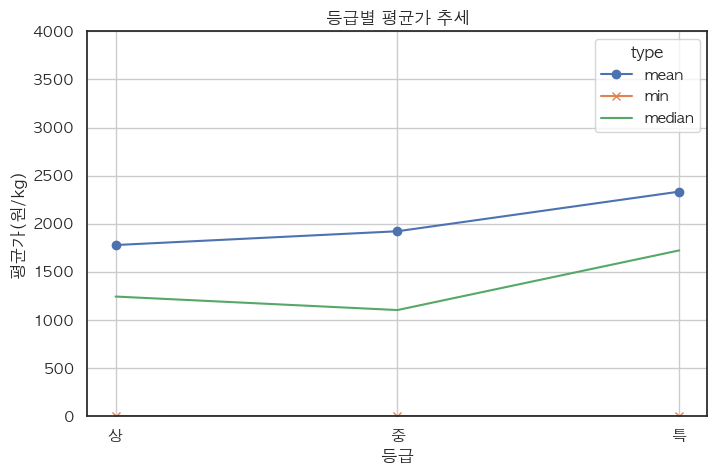

In [14]:
grade_mean = train_meta_산지공판장.groupby('등급')['평균가(원/kg)'].mean()
grade_min = train_meta_산지공판장.groupby('등급')['평균가(원/kg)'].min()
grade_max = train_meta_산지공판장.groupby('등급')['평균가(원/kg)'].max()
grade_median = train_meta_산지공판장.groupby('등급')['평균가(원/kg)'].median()

# 그래프 크기 설정
plt.figure(figsize=(8, 5))

# 꺾은선 그래프 그리기
plt.plot(grade_mean.index, grade_mean.values, label='mean', marker='o')
plt.plot(grade_min.index, grade_min.values, label='min', marker='x')
# plt.plot(grade_max.index, grade_max.values, label='max', marker='*')
plt.plot(grade_median.index, grade_median.values, label='median')

# 그래프 레이블 및 제목
plt.xlabel('등급')
plt.ylim((0, 4000))
plt.ylabel('평균가(원/kg)')
plt.title('등급별 평균가 추세')
plt.legend(title='type')
plt.grid(True)

# 그래프 출력
plt.show()

- 전체 품종에 대해 합쳐서 살펴보니 적절한 패턴이 보이지 않음

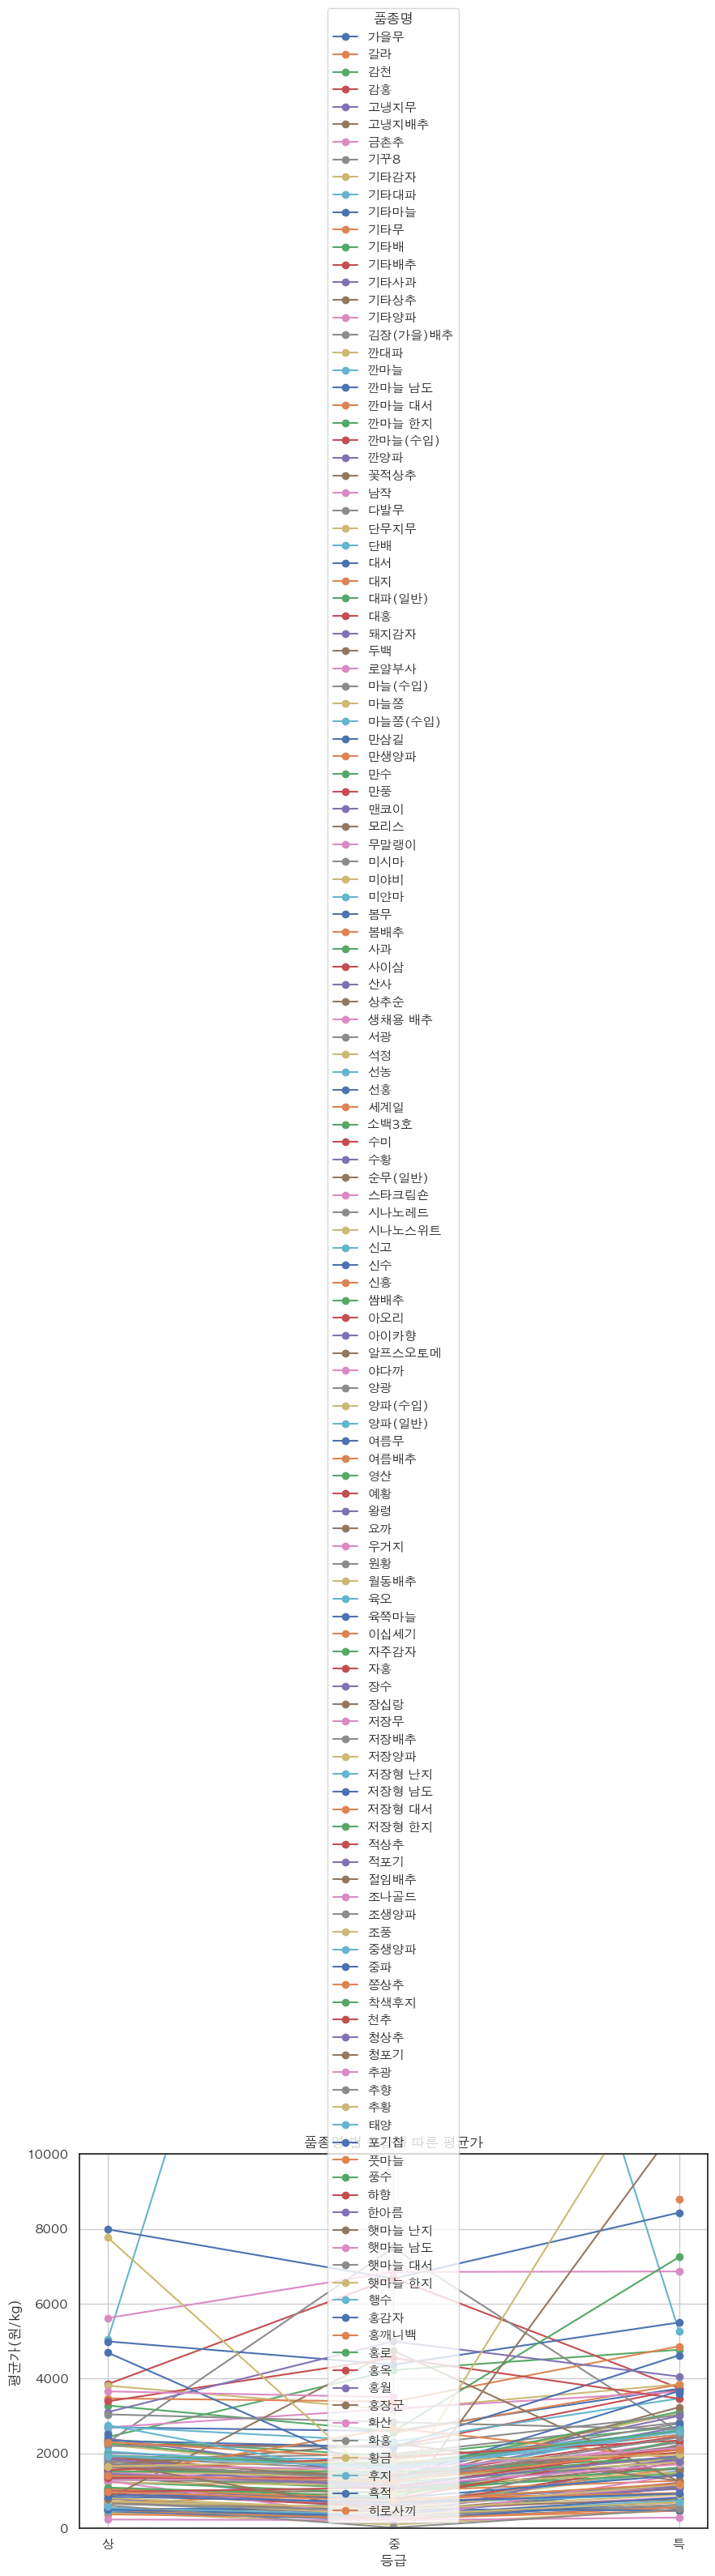

In [15]:
# 품종명과 등급별 평균가 그룹화
grouped_data = train_meta_산지공판장.groupby(['품종명', '등급'])['평균가(원/kg)'].mean().unstack()

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 각 품종명을 꺾은선 그래프로 그리기
for 품종명 in grouped_data.index:
    plt.plot(grouped_data.columns, grouped_data.loc[품종명], label=품종명, marker='o')

# 그래프 레이블 및 제목
plt.xlabel('등급')
plt.ylabel('평균가(원/kg)')
plt.ylim((0, 10000))
plt.title('품종명 별 등급에 따른 평균가')
plt.legend(title='품종명')
plt.grid(True)

# 그래프 출력
plt.show()

- 전체 품종을 보는 것도 어렵다..
- 몇개 품종을 샘플링해서 살펴보자.

In [16]:
targets = set(train_meta_산지공판장.groupby(['품종명'])['품종명'].value_counts().sort_values(ascending=False)[:10].index)

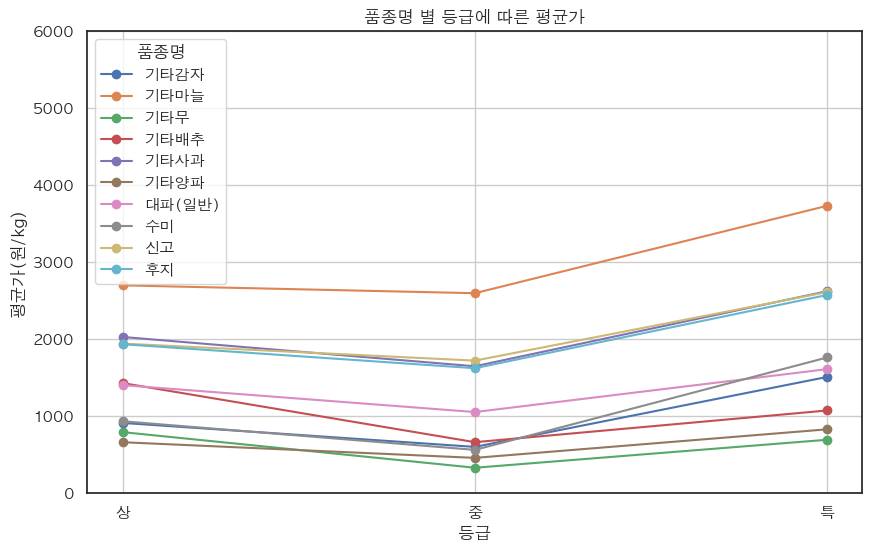

In [17]:
# 품종명과 등급별 평균가 그룹화
grouped_data = train_meta_산지공판장.groupby(['품종명', '등급'])['평균가(원/kg)'].mean().unstack()

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 각 품종명을 꺾은선 그래프로 그리기
for 품종명 in grouped_data.index:
    if 품종명 not in targets: continue
    plt.plot(grouped_data.columns, grouped_data.loc[품종명], label=품종명, marker='o')

# 그래프 레이블 및 제목
plt.xlabel('등급')
plt.ylabel('평균가(원/kg)')
plt.ylim((0, 6000))
plt.title('품종명 별 등급에 따른 평균가')
plt.legend(title='품종명')
plt.grid(True)

# 그래프 출력
plt.show()

- 개수 기준 상위 10개를 살펴봤을 때, '.' 등급은 상과 비슷한 수준으로 보이고, 4등 ~ 등외는 별차이가 없어 보통으로 처리하면 될 듯하다.

In [18]:
# train_meta_전국도매 = train_meta_전국도매.drop(['저가(20%) 평균가', '고가(20%) 평균가', '중가(60%) 평균가 '], axis=1)
# train_meta_전국도매['시장구분'] = '전국도매'

# train_meta_산지공판장 = train_meta_산지공판장.rename(columns={'공판장코드': '시장코드', '공판장명': '시장명'}).drop(['등급코드', '등급'], axis=1)
# train_meta_산지공판장['시장구분'] = '산지공판장'

# train_meta = pd.concat([train_meta_전국도매, train_meta_산지공판장])

# # train meta merge
# train_df = train_df.merge(train_meta, on=['시점', '품목명', '품종명'], how='left')

In [19]:
# train_meta_산지공판장 = train_meta_산지공판장.rename(columns={'공판장코드': '시장코드', '공판장명': '시장명'}).drop(['등급코드', '등급'], axis=1)
# train_meta_산지공판장['시장구분'] = '산지공판장'

In [20]:
# train_meta = pd.concat([train_meta_전국도매, train_meta_산지공판장])

In [21]:
# # train meta merge
# train_df = train_df.merge(train_meta, on=['시점', '품목명', '품종명'], how='left')

In [22]:
# # test meta merge
# for i, df in enumerate(test_dfs):
#     test_meta_전국도매 = pd.read_csv(os.path.join(DATA_DIR, 'test', 'meta', f"TEST_전국도매_{str(i).zfill(2)}.csv"))
#     test_meta_산지공판장 = pd.read_csv(os.path.join(DATA_DIR, 'test', 'meta', f"TEST_산지공판장_{str(i).zfill(2)}.csv"))
    
#     test_meta_전국도매 = test_meta_전국도매.drop(['저가(20%) 평균가', '고가(20%) 평균가', '중가(60%) 평균가 '], axis=1)
#     test_meta_전국도매['시장구분'] = '전국도매'

#     test_meta_산지공판장 = test_meta_산지공판장.rename(columns={'공판장코드': '시장코드', '공판장명': '시장명'}).drop(['등급코드', '등급명'], axis=1)
#     test_meta_산지공판장['시장구분'] = '산지공판장'
    
#     test_meta = pd.concat([test_meta_전국도매, test_meta_산지공판장])
#     test_dfs[i] = test_dfs[i].merge(test_meta, on=['시점', '품목명', '품종명'], how='left')

In [23]:
train_df['시장코드'].isna().sum() / train_df.shape[0] * 100

np.float64(20.701980327379285)

In [24]:
train_df.head()

,시점,품목명,품종명,거래단위,등급,평년 평균가격(원),평균가격(원),시장코드,시장명,품목코드,품종코드,총반입량(kg),총거래금액(원),평균가(원/kg),중간가(원/kg),최저가(원/kg),최고가(원/kg),경매 건수,전순 평균가격(원) PreVious SOON,전달 평균가격(원) PreVious MMonth,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,연도,시장구분
0,201801상순,건고추,화건,30 kg,상,381666.666667,590000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201801중순,건고추,화건,30 kg,상,380809.666667,590000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201801하순,건고추,화건,30 kg,상,380000.000000,590000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201802상순,건고추,화건,30 kg,상,380000.000000,590000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201802중순,건고추,화건,30 kg,상,376666.666667,590000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
train_df.dtypes

시점                              object
품목명                             object
품종명                             object
거래단위                            object
등급                              object
평년 평균가격(원)                     float64
평균가격(원)                        float64
시장코드                           float64
시장명                             object
품목코드                           float64
품종코드                           float64
총반입량(kg)                       float64
총거래금액(원)                       float64
평균가(원/kg)                      float64
중간가(원/kg)                      float64
최저가(원/kg)                      float64
최고가(원/kg)                      float64
경매 건수                          float64
전순 평균가격(원) PreVious SOON       float64
전달 평균가격(원) PreVious MMonth     float64
전년 평균가격(원) PreVious YeaR       float64
평년 평균가격(원) Common Year SOON    float64
연도                             float64
시장구분                            object
dtype: object

In [26]:
train_df.describe(include='all')

,시점,품목명,품종명,거래단위,등급,평년 평균가격(원),평균가격(원),시장코드,시장명,품목코드,품종코드,총반입량(kg),총거래금액(원),평균가(원/kg),중간가(원/kg),최저가(원/kg),최고가(원/kg),경매 건수,전순 평균가격(원) PreVious SOON,전달 평균가격(원) PreVious MMonth,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,연도,시장구분
count,107154,107154,107154,107154,107154,1.071540e+05,1.071540e+05,8.497100e+04,84971,84971.000000,84971.000000,8.497100e+04,8.497100e+04,84971.000000,8.497100e+04,84971.000000,8.497100e+04,84971.000000,8.497100e+04,8.497100e+04,8.497100e+04,8.497100e+04,84971.000000,84971
unique,144,10,40,25,4,NaN,NaN,NaN,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,201809중순,양파,다발무,10 개,중,NaN,NaN,NaN,*전국농협공판장,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,전국도매
freq,1084,24790,18045,17224,65457,NaN,NaN,NaN,6491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54207
mean,NaN,NaN,NaN,NaN,NaN,2.770015e+04,1.069053e+05,1.302136e+09,NaN,1016.286168,101634.132869,1.300963e+05,1.588812e+08,1255.115429,1.291665e+03,726.674059,3.438439e+03,72.088407,1.567323e+03,2.205680e+03,1.241452e+04,2.735441e+04,2019.457450,NaN
std,NaN,NaN,NaN,NaN,NaN,2.781662e+05,8.015806e+05,2.014107e+09,NaN,231.277306,23125.486547,7.160307e+05,1.201785e+09,1195.033107,6.349774e+03,993.847527,5.010901e+04,358.680506,3.314765e+04,5.176048e+04,1.825680e+05,2.214862e+05,1.108384,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,1.000000e+05,NaN,501.000000,50100.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,-2.525253e+02,-2.525253e+02,-2.525253e+02,0.000000e+00,2018.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,2.500010e+05,NaN,1001.000000,100108.000000,7.200000e+02,6.443900e+05,560.000000,5.625000e+02,230.000000,8.000000e+02,4.000000,4.136364e+02,2.840000e+02,3.106474e+02,0.000000e+00,2018.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.558500e+03,3.504020e+05,NaN,1101.000000,110106.000000,6.160000e+03,5.884390e+06,943.493493,9.555556e+02,495.522388,1.483333e+03,15.000000,8.476725e+02,7.842281e+02,8.812036e+02,0.000000e+00,2019.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.206074e+03,1.300000e+04,3.078200e+09,NaN,1201.000000,120106.000000,3.713150e+04,3.982985e+07,1578.792183,1.597361e+03,931.428571,2.784194e+03,50.000000,1.483302e+03,1.432786e+03,1.755981e+03,3.332749e+03,2020.000000,NaN


In [27]:
품종_거래단위_등급별_시점 = train_df[['시점','품종명', '품목명', '거래단위', '등급']].groupby(['품목명', '품종명', '거래단위', '등급']).agg(lambda x: len(set(x)))

In [28]:
품종_거래단위_등급별_시점[품종_거래단위_등급별_시점['시점'] != 144]

,,,,시점
품목명,품종명,거래단위,등급,


In [29]:
홍로_후지_상품 = train_df[(train_df['품종명'].isin(['홍로','후지'])) & (train_df['등급'] == '상품')].sort_values('시점')

In [30]:
홍로_후지_상품['시점'].nunique()

0

- 품종,거래단위,등급 별 데이터의 수를 살펴보면, 모두 144개로 3x4x12 4년치의 순별 데이터가 모두 존재함을 알 수 있다.
- 다만, 사과의 홍로, 후지의 경우 '상품'의 데이터가 비어있는데, 두개를 합치면 144개 시점 모두가 채워진다. 즉 홍로와, 후지는 동일한 품종으로 처리해야 함.

In [31]:
# 품목별 품종, 거래단위, 등급 의 개수
train_df[['품목명', '품종명', '거래단위', '등급']].groupby('품목명').agg({'품종명': set, '거래단위':set, '등급': set})

,품종명,거래단위,등급
품목명,,,
감자,"{감자 두백, 감자 수입, 감자 수미(저장), 홍감자, 감자 수미(햇), 감자 대지...","{10키로상자, 23키로상자, 20키로상자}","{중, 특, 상, 하}"
건고추,"{양건, 햇산양건, 화건, 햇산화건}",{30 kg},"{중, 상}"
깐마늘(국산),{깐마늘(국산)},{20 kg},"{중, 상}"
대파,"{실파, 쪽파, 대파 수입, 대파(일반), 깐쪽파}","{10키로상자, 10키로묶음, 1키로단, 20키로}","{중, 특, 상, 하}"
무,"{열무, 다발무, 무}","{1000키로, 18키로상자(비닐포), 10키로, 20키로상자, 4키로상자, 1.5...","{중, 특, 상, 하}"
배,"{신고, 원황}",{10 개},"{중, 상}"
배추,"{알배기배추, 절임배추, 얼갈이배추, 배추, 쌈배추, 봄동배추}","{8키로상자, 10키로망대, 15키로상자, 4키로상자, 20키로상자, 1키로상자}","{중, 특, 상, 하}"
사과,"{쓰가루, 홍로}",{10 개},"{중, 상}"
상추,"{청, 적}",{100 g},"{중, 상}"


In [32]:
train_df[['품목명', '등급', '거래단위']].groupby(['품목명', '등급']).agg({'거래단위': set})

거래단위
품목명     등급                                                   
감자      상                            {10키로상자, 23키로상자, 20키로상자}
        중                                    {10키로상자, 20키로상자}
        특                                    {10키로상자, 20키로상자}
        하                                    {10키로상자, 20키로상자}
건고추     상                                             {30 kg}
        중                                             {30 kg}
깐마늘(국산) 상                                             {20 kg}
        중                                             {20 kg}
대파      상                        {10키로상자, 10키로묶음, 1키로단, 20키로}
        중                        {10키로상자, 10키로묶음, 1키로단, 20키로}
        특                        {10키로상자, 10키로묶음, 1키로단, 20키로}
        하                        {10키로상자, 10키로묶음, 1키로단, 20키로}
무       상   {1000키로, 1.5키로단, 4키로상자, 20키로상자, 8톤트럭, 10키로, 18...
        중   {1000키로, 18키로상자(비닐포), 20키로상자, 10키로, 4키로상자, 1.5...
        특   {1000키로, 18키로상자(비닐포), 20키로상자, 10키로, 5톤트럭, 5000키로}
        하   {1000키로, 1.5키로단, 20키로상자, 10키로, 4키로상자, 8톤트럭, 18...
배       상                                              {10 개}
        중                                              {10 개}
배추      상       {8키로상자, 10키로망대, 15키로상자, 4키로상자, 20키로상자, 1키로상자}
        중               {8키로상자, 10키로망대, 15키로상자, 4키로상자, 1키로상자}
        특                              {8키로상자, 10키로망대, 1키로상자}
        하               {8키로상자, 10키로망대, 15키로상자, 4키로상자, 1키로상자}
사과      상                                              {10 개}
        중                                              {10 개}
상추      상                                             {100 g}
        중                                             {100 g}
양파      상                       {20키로, 10키로, 1키로, 15키로, 12키로}
        중                       {20키로, 10키로, 1키로, 15키로, 12키로}
        특                       {20키로, 10키로, 1키로, 15키로, 12키로}
        하                       {20키로, 10키로, 1키로, 15키로, 12키로}

- 품목별로 다양한 품종이 존재하고, 각 품종별로 등급이 존재. 품종/등급을 거래 단위로 묶어 판매함

In [33]:
train_df[['품목명','품종명', '등급', '거래단위']].groupby(['품목명','품종명', '등급']).agg({'거래단위': set})

거래단위
품목명 품종명   등급                    
감자  감자    상             {20키로상자}
          중             {20키로상자}
          특             {20키로상자}
          하             {20키로상자}
    감자 대지 상             {20키로상자}
...                          ...
양파  저장양파  하   {15키로, 12키로, 20키로}
    조생양파  상         {15키로, 12키로}
          중         {15키로, 12키로}
          특         {15키로, 12키로}
          하         {15키로, 12키로}

[126 rows x 1 columns]

- 다발무의 '특' 을 제외하고, 같은 품종인 경우 같은 거래단위로 판매됨
- 등급은 모든 품종에 대해 [특, 상, 중, 하] 범주에서 구분 가능

---

In [34]:
set(train_df.columns) - set(test_dfs[0].columns)

set()

- train 데이터와 test 데이터간 원본 feature 차이는 없음

In [35]:
test_dfs[0].shape

(6874, 24)

In [36]:
테스트_품목_품종_거래단위_등급 = [test_df[['품목명', '품종명', '거래단위', '등급', '시점']].groupby(['품목명','품종명','거래단위','등급']).agg(lambda x: len(set(x))) for test_df in test_dfs]

In [37]:
for data in 테스트_품목_품종_거래단위_등급:
    if data[data['시점'] != 9].shape[0] > 0:
        print("전처리 에러")

In [38]:
test_dfs[0].describe(include='all')

,시점,품목명,품종명,거래단위,등급,평년 평균가격(원),평균가격(원),시장코드,시장명,품목코드,품종코드,총반입량(kg),총거래금액(원),평균가(원/kg),중간가(원/kg),최저가(원/kg),최고가(원/kg),경매 건수,전순 평균가격(원) PreVious SOON,전달 평균가격(원) PreVious MMonth,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,연도,시장구분
count,6874,6874,6874,6874,6874,6874.000000,6874.000000,5.487000e+03,5487,5487.000000,5487.000000,5.487000e+03,5.487000e+03,5487.000000,5487.000000,5487.000000,5487.000000,5487.000000,5487.000000,5487.000000,5487.000000,5487.000000,5487.0,5487
unique,9,10,40,25,4,NaN,NaN,NaN,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,T,양파,대파(일반),10 개,중,NaN,NaN,NaN,*전국농협공판장,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,전국도매
freq,871,1276,1036,1767,4210,NaN,NaN,NaN,464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3381
mean,NaN,NaN,NaN,NaN,NaN,9809.763623,17175.439115,1.362193e+09,NaN,945.412976,94548.201385,1.269423e+05,2.393249e+08,1772.436313,1757.507416,1001.839672,3613.417040,76.712776,1523.692000,1377.030618,1207.567219,1061.265277,2022.0,NaN
std,NaN,NaN,NaN,NaN,NaN,43858.484027,59760.421271,2.043749e+09,NaN,261.332266,26129.820850,7.539184e+05,1.772506e+09,1036.688334,1038.282348,861.728331,5110.854657,431.608815,1165.880653,1230.991363,1189.032216,1135.626732,0.0,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000e+05,NaN,501.000000,50118.000000,1.000000e+00,1.000000e+03,62.500000,62.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2022.0,NaN
25%,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,2.500010e+05,NaN,602.000000,60201.000000,4.480000e+02,5.757500e+05,1057.828278,1056.696429,489.000000,1333.333333,3.000000,776.470775,0.000000,411.569718,0.000000,2022.0,NaN
50%,NaN,NaN,NaN,NaN,NaN,0.000000,4583.142857,3.603010e+05,NaN,1001.000000,100108.000000,3.194000e+03,4.809159e+06,1599.678894,1577.946640,806.666667,2250.000000,12.000000,1452.171322,1271.196824,974.085366,819.930856,2022.0,NaN
75%,NaN,NaN,NaN,NaN,NaN,13296.541667,20432.000000,3.078200e+09,NaN,1201.000000,120106.000000,2.105000e+04,3.940333e+07,2170.208323,2133.333333,1300.000000,3752.688172,47.000000,2104.618636,2066.416447,1646.319115,1811.722271,2022.0,NaN


### 1-1. 분석 목적 + 목적 별 변수 지정

- 각 데이터 포인트는 10일 단위로 구성됨
- train 데이터는 2018 ~ 2021년의 시계열 데이터가 존재
- test 데이터는 임의의 추론 시점 T 기준 과거 T-8 까지 3개월의 데이터를 입력으로 T+1, T+2, T+3 단위의 평균가격을 예측해야 함
- Many To Many 회귀 테스트
- 사용 가능한 feature set:
  - 품목명
  - 품종명
  - 거래단위
  - 등급
  - 평년가격
- Target: 평균가격

In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107154 entries, 0 to 107153
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   시점                           107154 non-null  object 
 1   품목명                          107154 non-null  object 
 2   품종명                          107154 non-null  object 
 3   거래단위                         107154 non-null  object 
 4   등급                           107154 non-null  object 
 5   평년 평균가격(원)                   107154 non-null  float64
 6   평균가격(원)                      107154 non-null  float64
 7   시장코드                         84971 non-null   float64
 8   시장명                          84971 non-null   object 
 9   품목코드                         84971 non-null   float64
 10  품종코드                         84971 non-null   float64
 11  총반입량(kg)                     84971 non-null   float64
 12  총거래금액(원)                     84971 non-null   float64
 13 

In [40]:
테스트_병합 = pd.concat(test_dfs)

In [41]:
테스트_병합.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162323 entries, 0 to 5991
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   시점                           162323 non-null  object 
 1   품목명                          162323 non-null  object 
 2   품종명                          162323 non-null  object 
 3   거래단위                         162323 non-null  object 
 4   등급                           162323 non-null  object 
 5   평년 평균가격(원)                   162323 non-null  float64
 6   평균가격(원)                      162323 non-null  float64
 7   시장코드                         127329 non-null  float64
 8   시장명                          127329 non-null  object 
 9   품목코드                         127329 non-null  float64
 10  품종코드                         127329 non-null  float64
 11  총반입량(kg)                     127329 non-null  float64
 12  총거래금액(원)                     127329 non-null  float64
 13  평균가(원/

---
### 1-2. 데이터 타입 확인

In [42]:
train_df.dtypes

시점                              object
품목명                             object
품종명                             object
거래단위                            object
등급                              object
평년 평균가격(원)                     float64
평균가격(원)                        float64
시장코드                           float64
시장명                             object
품목코드                           float64
품종코드                           float64
총반입량(kg)                       float64
총거래금액(원)                       float64
평균가(원/kg)                      float64
중간가(원/kg)                      float64
최저가(원/kg)                      float64
최고가(원/kg)                      float64
경매 건수                          float64
전순 평균가격(원) PreVious SOON       float64
전달 평균가격(원) PreVious MMonth     float64
전년 평균가격(원) PreVious YeaR       float64
평년 평균가격(원) Common Year SOON    float64
연도                             float64
시장구분                            object
dtype: object

In [43]:
테스트_병합.dtypes

시점                              object
품목명                             object
품종명                             object
거래단위                            object
등급                              object
평년 평균가격(원)                     float64
평균가격(원)                        float64
시장코드                           float64
시장명                             object
품목코드                           float64
품종코드                           float64
총반입량(kg)                       float64
총거래금액(원)                       float64
평균가(원/kg)                      float64
중간가(원/kg)                      float64
최저가(원/kg)                      float64
최고가(원/kg)                      float64
경매 건수                          float64
전순 평균가격(원) PreVious SOON       float64
전달 평균가격(원) PreVious MMonth     float64
전년 평균가격(원) PreVious YeaR       float64
평년 평균가격(원) Common Year SOON    float64
연도                             float64
시장구분                            object
dtype: object

---
### 1-3. 오류, 누락 확인

In [44]:
object_features = ['시점', '품목명', '품종명', '거래단위', '등급', '시장명', '시장구분']

In [45]:
train_df[train_df['시장명'].isna()].groupby('품종명')['품종명'].value_counts() / train_df.groupby('품종명')['품종명'].value_counts() * 100

품종명
감자            45.134384
감자 대지        100.000000
감자 두백        100.000000
감자 수미        100.000000
감자 수미(저장)    100.000000
감자 수미(햇)     100.000000
감자 수입        100.000000
감자 조풍        100.000000
깐마늘(국산)      100.000000
깐쪽파          100.000000
다발무            4.893322
대파 수입        100.000000
대파(일반)         1.703739
무             43.103448
배추            34.090909
봄동배추         100.000000
신고                  NaN
실파           100.000000
쌈배추            2.053037
쓰가루          100.000000
알배기배추        100.000000
양건           100.000000
양파            41.004566
양파 수입        100.000000
양파(햇)        100.000000
얼갈이배추        100.000000
열무           100.000000
원황            11.117107
자주양파          14.911978
저장양파          16.727273
적            100.000000
절임배추          95.918367
조생양파          21.543027
쪽파           100.000000
청            100.000000
햇산양건         100.000000
햇산화건         100.000000
홍감자           29.799852
홍로             3.925385
화건           100.000000
Name: count, dtype: float64

- 원본 feature에는 결측치가 없고, meta 정보가 없는 대상들이 존재함.

#### Numeric 값 결측치

In [46]:
train_df.columns

Index(['시점', '품목명', '품종명', '거래단위', '등급', '평년 평균가격(원)', '평균가격(원)', '시장코드',
       '시장명', '품목코드', '품종코드', '총반입량(kg)', '총거래금액(원)', '평균가(원/kg)', '중간가(원/kg)',
       '최저가(원/kg)', '최고가(원/kg)', '경매 건수', '전순 평균가격(원) PreVious SOON',
       '전달 평균가격(원) PreVious MMonth', '전년 평균가격(원) PreVious YeaR',
       '평년 평균가격(원) Common Year SOON', '연도', '시장구분'],
      dtype='object')

In [47]:
numeric_features = list(set(train_df.columns) - set(object_features))

In [48]:
train_df[numeric_features].describe()

,최고가(원/kg),평균가(원/kg),중간가(원/kg),연도,평균가격(원),전달 평균가격(원) PreVious MMonth,총반입량(kg),총거래금액(원),경매 건수,최저가(원/kg),품종코드,품목코드,전순 평균가격(원) PreVious SOON,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,평년 평균가격(원),시장코드
count,8.497100e+04,84971.000000,8.497100e+04,84971.000000,1.071540e+05,8.497100e+04,8.497100e+04,8.497100e+04,84971.000000,84971.000000,84971.000000,84971.000000,8.497100e+04,8.497100e+04,8.497100e+04,1.071540e+05,8.497100e+04
mean,3.438439e+03,1255.115429,1.291665e+03,2019.457450,1.069053e+05,2.205680e+03,1.300963e+05,1.588812e+08,72.088407,726.674059,101634.132869,1016.286168,1.567323e+03,1.241452e+04,2.735441e+04,2.770015e+04,1.302136e+09
std,5.010901e+04,1195.033107,6.349774e+03,1.108384,8.015806e+05,5.176048e+04,7.160307e+05,1.201785e+09,358.680506,993.847527,23125.486547,231.277306,3.314765e+04,1.825680e+05,2.214862e+05,2.781662e+05,2.014107e+09
min,0.000000e+00,0.000000,0.000000e+00,2018.000000,0.000000e+00,-2.525253e+02,0.000000e+00,0.000000e+00,1.000000,0.000000,50100.000000,501.000000,-2.525253e+02,-2.525253e+02,0.000000e+00,0.000000e+00,1.000000e+05
25%,8.000000e+02,560.000000,5.625000e+02,2018.000000,0.000000e+00,2.840000e+02,7.200000e+02,6.443900e+05,4.000000,230.000000,100108.000000,1001.000000,4.136364e+02,3.106474e+02,0.000000e+00,0.000000e+00,2.500010e+05
50%,1.483333e+03,943.493493,9.555556e+02,2019.000000,1.558500e+03,7.842281e+02,6.160000e+03,5.884390e+06,15.000000,495.522388,110106.000000,1101.000000,8.476725e+02,8.812036e+02,0.000000e+00,0.000000e+00,3.504020e+05
75%,2.784194e+03,1578.792183,1.597361e+03,2020.000000,1.300000e+04,1.432786e+03,3.713150e+04,3.982985e+07,50.000000,931.428571,120106.000000,1201.000000,1.483302e+03,1.755981e+03,3.332749e+03,1.206074e+03,3.078200e+09
max,4.216786e+06,69200.000000,1.050700e+06,2021.000000,1.335000e+07,3.061080e+06,2.962043e+07,7.496361e+10,18795.000000,69200.000000,120201.000000,1202.000000,2.991672e+06,8.405393e+06,3.699690e+06,5.213802e+06,6.738200e+09


In [49]:
# train_df[numeric_features] = train_df[numeric_features].apply(lambda c: c.replace(.0, c.mean()))
train_df['평균가(원/kg)_mean'] = train_df.groupby(['품목명', '품종명', '거래단위', '등급', '연도', '시장구분'])['평균가(원/kg)'].transform('mean')

In [50]:
train_df[['품목명', '품종명', '거래단위', '등급', '연도', '시장구분', '평균가(원/kg)', '평균가(원/kg)_mean']].groupby(['품종명', '연도', '등급', '시장구분']).describe()

평균가(원/kg)                                        \
                        count         mean          std         min   
품종명 연도     등급 시장구분                                                    
감자  2018.0 중  전국도매      255.0  1732.722840   913.555823  216.666667   
    2019.0 중  전국도매      241.0   976.456963   467.208055  261.751412   
    2020.0 중  전국도매       96.0  1008.173967   419.571576  196.435845   
다발무 2018.0 중  산지공판장     275.0   335.372859   290.687271   58.258929   
              전국도매     2440.0   552.859348   556.465811   38.185032   
...                       ...          ...          ...         ...   
홍로  2020.0 중  전국도매      620.0  3304.014321  1214.315676  220.000000   
           상  산지공판장     252.0  2619.152666  1652.188148  320.000000   
    2021.0 중  산지공판장     548.0  1456.630463   957.445691  100.000000   
              전국도매      644.0  2323.063767  1081.975082    0.000000   
           상  산지공판장     201.0  1843.469381  1240.344640  150.000000   

                                                                          \
                             25%          50%          75%           max   
품종명 연도     등급 시장구분                                                         
감자  2018.0 중  전국도매   1200.787671  1517.660377  1969.812897   4874.618096   
    2019.0 중  전국도매    652.654505   808.043478  1293.025614   4280.000000   
    2020.0 중  전국도매    731.269837   930.697787  1302.700811   2130.232336   
다발무 2018.0 중  산지공판장   143.230852   206.475584   400.000000   1166.666667   
              전국도매    310.229747   446.506822   605.207219   6400.000000   
...                          ...          ...          ...           ...   
홍로  2020.0 중  전국도매   2691.764706  3380.648673  3980.118846   7183.555556   
           상  산지공판장  1674.621212  2264.416237  3066.064694  12060.000000   
    2021.0 중  산지공판장   792.270257  1192.114002  1907.795276   5000.000000   
              전국도매   1387.089810  2328.109418  3161.636273   7600.000000   
           상  산지공판장  1046.666667  1500.000000  2306.896552   7785.000000   

                    평균가(원/kg)_mean                                          \
                             count         mean           std          min   
품종명 연도     등급 시장구분                                                           
감자  2018.0 중  전국도매           255.0  1732.722840  2.278208e-13  1732.722840   
    2019.0 중  전국도매           241.0   976.456963  3.417703e-13   976.456963   
    2020.0 중  전국도매            96.0  1008.173967  2.285672e-13  1008.173967   
다발무 2018.0 중  산지공판장          275.0   335.372859  0.000000e+00   335.372859   
              전국도매          2440.0   552.859348  0.000000e+00   552.859348   
...                            ...          ...           ...          ...   
홍로  2020.0 중  전국도매           620.0  3304.014321  4.551145e-13  3304.014321   
           상  산지공판장          252.0  2619.152666  0.000000e+00  2619.152666   
    2021.0 중  산지공판장          548.0  1456.630463  2.275814e-13  1456.630463   
              전국도매           644.0  2323.063767  4.551008e-13  2323.063767   
           상  산지공판장          201.0  1843.469381  2.279414e-13  1843.469381   

                                                                         
                             25%          50%          75%          max  
품종명 연도     등급 시장구분                                                       
감자  2018.0 중  전국도매   1732.722840  1732.722840  1732.722840  1732.722840  
    2019.0 중  전국도매    976.456963   976.456963   976.456963   976.456963  
    2020.0 중  전국도매   1008.173967  1008.173967  1008.173967  1008.173967  
다발무 2018.0 중  산지공판장   335.372859   335.372859   335.372859   335.372859  
              전국도매    552.859348   552.859348   552.859348   552.859348  
...                          ...          ...          ...          ...  
홍로  2020.0 중  전국도매   3304.014321  3304.014321  3304.014321  3304.014321  
           상  산지공판장  2619.152666  2619.152666  2619.152666  2619.152666  
    2021.0 중  산지공판장  1456.630463  1456.630463  1456.6

In [51]:
train_df[numeric_features].describe()

,최고가(원/kg),평균가(원/kg),중간가(원/kg),연도,평균가격(원),전달 평균가격(원) PreVious MMonth,총반입량(kg),총거래금액(원),경매 건수,최저가(원/kg),품종코드,품목코드,전순 평균가격(원) PreVious SOON,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,평년 평균가격(원),시장코드
count,8.497100e+04,84971.000000,8.497100e+04,84971.000000,1.071540e+05,8.497100e+04,8.497100e+04,8.497100e+04,84971.000000,84971.000000,84971.000000,84971.000000,8.497100e+04,8.497100e+04,8.497100e+04,1.071540e+05,8.497100e+04
mean,3.438439e+03,1255.115429,1.291665e+03,2019.457450,1.069053e+05,2.205680e+03,1.300963e+05,1.588812e+08,72.088407,726.674059,101634.132869,1016.286168,1.567323e+03,1.241452e+04,2.735441e+04,2.770015e+04,1.302136e+09
std,5.010901e+04,1195.033107,6.349774e+03,1.108384,8.015806e+05,5.176048e+04,7.160307e+05,1.201785e+09,358.680506,993.847527,23125.486547,231.277306,3.314765e+04,1.825680e+05,2.214862e+05,2.781662e+05,2.014107e+09
min,0.000000e+00,0.000000,0.000000e+00,2018.000000,0.000000e+00,-2.525253e+02,0.000000e+00,0.000000e+00,1.000000,0.000000,50100.000000,501.000000,-2.525253e+02,-2.525253e+02,0.000000e+00,0.000000e+00,1.000000e+05
25%,8.000000e+02,560.000000,5.625000e+02,2018.000000,0.000000e+00,2.840000e+02,7.200000e+02,6.443900e+05,4.000000,230.000000,100108.000000,1001.000000,4.136364e+02,3.106474e+02,0.000000e+00,0.000000e+00,2.500010e+05
50%,1.483333e+03,943.493493,9.555556e+02,2019.000000,1.558500e+03,7.842281e+02,6.160000e+03,5.884390e+06,15.000000,495.522388,110106.000000,1101.000000,8.476725e+02,8.812036e+02,0.000000e+00,0.000000e+00,3.504020e+05
75%,2.784194e+03,1578.792183,1.597361e+03,2020.000000,1.300000e+04,1.432786e+03,3.713150e+04,3.982985e+07,50.000000,931.428571,120106.000000,1201.000000,1.483302e+03,1.755981e+03,3.332749e+03,1.206074e+03,3.078200e+09
max,4.216786e+06,69200.000000,1.050700e+06,2021.000000,1.335000e+07,3.061080e+06,2.962043e+07,7.496361e+10,18795.000000,69200.000000,120201.000000,1202.000000,2.991672e+06,8.405393e+06,3.699690e+06,5.213802e+06,6.738200e+09


In [52]:
print("train data")
for feature in numeric_features:
    print(f"{feature} 결측치 비율 : {train_df[train_df[feature] == .0].shape[0] / train_df.shape[0] * 100} %")

train data
최고가(원/kg) 결측치 비율 : 0.09332362767605502 %
평균가(원/kg) 결측치 비율 : 0.017731489258450455 %
중간가(원/kg) 결측치 비율 : 0.026130615749295406 %
연도 결측치 비율 : 0.0 %
평균가격(원) 결측치 비율 : 40.41473020139239 %
전달 평균가격(원) PreVious MMonth 결측치 비율 : 17.31993206039905 %
총반입량(kg) 결측치 비율 : 0.017731489258450455 %
총거래금액(원) 결측치 비율 : 0.017731489258450455 %
경매 건수 결측치 비율 : 0.0 %
최저가(원/kg) 결측치 비율 : 2.5803983052429214 %
품종코드 결측치 비율 : 0.0 %
품목코드 결측치 비율 : 0.0 %
전순 평균가격(원) PreVious SOON 결측치 비율 : 11.24363066241111 %
전년 평균가격(원) PreVious YeaR 결측치 비율 : 16.150587005618082 %
평년 평균가격(원) Common Year SOON 결측치 비율 : 46.4089068070254 %
평년 평균가격(원) 결측치 비율 : 71.82093062321519 %
시장코드 결측치 비율 : 0.0 %


- train 데이터에서 target 값이 0인 경우가 39%로 굉장히 높다

In [53]:
print("test data")
for feature in numeric_features:
    print(f"{feature} 결측치 비율 : {테스트_병합[테스트_병합[feature] == .0].shape[0] / 테스트_병합.shape[0] * 100} %")

test data
최고가(원/kg) 결측치 비율 : 0.011705057200766374 %
평균가(원/kg) 결측치 비율 : 0.0 %
중간가(원/kg) 결측치 비율 : 0.0 %
연도 결측치 비율 : 0.0 %
평균가격(원) 결측치 비율 : 30.10602317601326 %
전달 평균가격(원) PreVious MMonth 결측치 비율 : 18.76259063718635 %
총반입량(kg) 결측치 비율 : 0.0 %
총거래금액(원) 결측치 비율 : 0.0 %
경매 건수 결측치 비율 : 0.0 %
최저가(원/kg) 결측치 비율 : 2.718037493146381 %
품종코드 결측치 비율 : 0.0 %
품목코드 결측치 비율 : 0.0 %
전순 평균가격(원) PreVious SOON 결측치 비율 : 12.347603235524232 %
전년 평균가격(원) PreVious YeaR 결측치 비율 : 14.785951467136513 %
평년 평균가격(원) Common Year SOON 결측치 비율 : 30.32780320718567 %
평년 평균가격(원) 결측치 비율 : 54.721758469224945 %
시장코드 결측치 비율 : 0.0 %


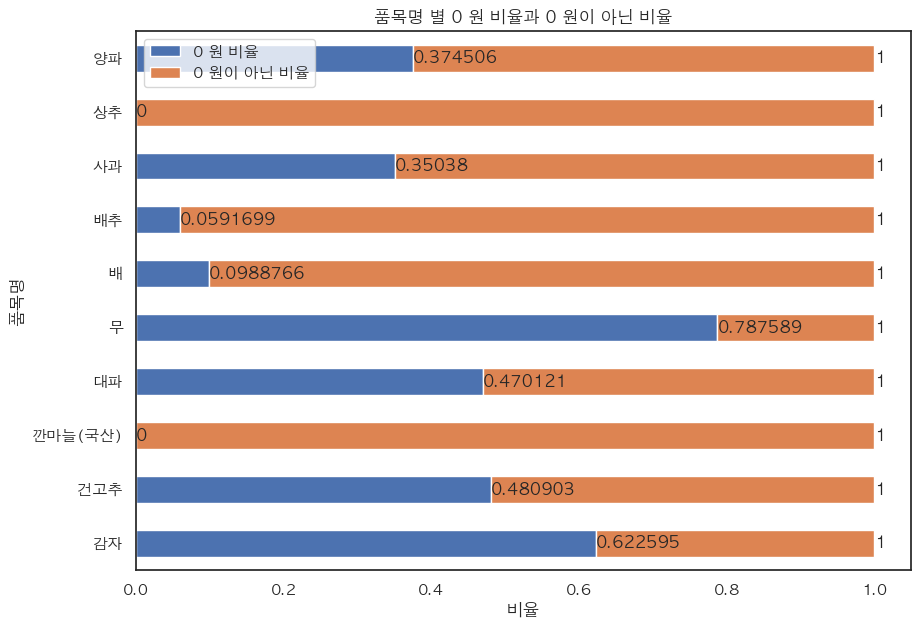

In [54]:
# 1. 품목명 별로 평균가격(원)이 0인 경우와 그렇지 않은 경우의 비율 계산
price_zero_ratio = train_df.groupby('품목명')['평균가격(원)'].apply(lambda x: (x == 0).sum() / x.shape[0])
price_non_zero_ratio = train_df.groupby('품목명')['평균가격(원)'].apply(lambda x: (x != 0).sum() / x.shape[0])

# 2. 두 데이터를 하나의 DataFrame으로 합침
ratio_df = pd.DataFrame({
    '0 원 비율': price_zero_ratio,
    '0 원이 아닌 비율': price_non_zero_ratio
})

# 3. Horizontal Bar Chart 그리기
ax = ratio_df.plot(kind='barh', stacked=True, figsize=(10, 7))

# 그래프 제목과 레이블 설정
plt.title('품목명 별 0 원 비율과 0 원이 아닌 비율')
plt.xlabel('비율')
plt.ylabel('품목명')

# 4. 각 막대에 값 표시
for container in ax.containers:
    ax.bar_label(container)

# 그래프 출력
plt.show()

- target이 결측인 경우 사용이 불가하므로, 제거한 상태로 변환

In [55]:
train_with_target_df = train_df[train_df['평균가격(원)'] != .0]
test_with_target_df = 테스트_병합[테스트_병합['평균가격(원)'] != .0]

In [56]:
train_with_target_df.shape

(63848, 25)

In [57]:
test_with_target_df.shape

(113454, 24)

---
### 1-4. 예측 범위 분포 확인

In [58]:
train_with_target_df.describe()

,평년 평균가격(원),평균가격(원),시장코드,품목코드,품종코드,총반입량(kg),총거래금액(원),평균가(원/kg),중간가(원/kg),최저가(원/kg),최고가(원/kg),경매 건수,전순 평균가격(원) PreVious SOON,전달 평균가격(원) PreVious MMonth,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,연도,평균가(원/kg)_mean
count,6.384800e+04,6.384800e+04,5.062000e+04,50620.000000,50620.000000,5.062000e+04,5.062000e+04,50620.000000,5.062000e+04,50620.000000,5.062000e+04,50620.000000,50620.000000,50620.000000,5.062000e+04,5.062000e+04,50620.000000,50620.000000
mean,4.648825e+04,1.794157e+05,1.282653e+09,972.057171,97211.045358,1.073826e+05,1.595473e+08,1426.684789,1.477064e+03,814.846787,4.109086e+03,75.069597,1314.553770,1287.420265,6.403426e+03,1.493220e+04,2019.482438,1431.776822
std,3.591459e+05,1.032151e+06,2.039246e+09,245.612749,24559.832995,6.541497e+05,1.303625e+09,1249.417604,6.715903e+03,1056.858182,5.677481e+04,375.141832,1576.667198,3752.427388,9.687622e+04,1.519959e+05,1.095883,664.524208
min,0.000000e+00,1.341250e+02,1.000000e+05,501.000000,50100.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,1.000000,-252.525253,-252.525253,-2.525253e+02,0.000000e+00,2018.000000,330.497590
25%,0.000000e+00,3.468571e+03,2.500010e+05,602.000000,60201.000000,9.540000e+02,1.039930e+06,700.000000,7.075000e+02,277.541667,1.000000e+03,5.000000,566.559710,467.672414,4.594317e+02,0.000000e+00,2019.000000,907.328886
50%,0.000000e+00,9.998333e+03,3.503010e+05,1001.000000,100108.000000,6.825000e+03,7.291900e+06,1134.498250,1.150000e+03,571.259305,1.845329e+03,18.000000,1050.983408,980.306024,1.075450e+03,0.000000e+00,2019.000000,1408.588925
75%,1.427433e+04,2.110200e+04,3.048206e+09,1201.000000,120106.000000,3.540000e+04,4.283400e+07,1818.025980,1.831722e+03,1066.666667,3.377288e+03,52.000000,1745.515740,1687.601320,1.999633e+03,5.514723e+03,2020.000000,1868.553016
max,5.213802e+06,1.335000e+07,6.738200e+09,1202.000000,120201.000000,2.962043e+07,7.496361e+10,69200.000000,1.050700e+06,69200.000000,4.216786e+06,18795.000000,222934.397622,748144.028290,3.494734e+06,3.699690e+06,2021.000000,3496.526883


In [59]:
test_with_target_df.describe()

,평년 평균가격(원),평균가격(원),시장코드,품목코드,품종코드,총반입량(kg),총거래금액(원),평균가(원/kg),중간가(원/kg),최저가(원/kg),최고가(원/kg),경매 건수,전순 평균가격(원) PreVious SOON,전달 평균가격(원) PreVious MMonth,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,연도
count,113454.000000,1.134540e+05,8.938100e+04,89381.000000,89381.000000,8.938100e+04,8.938100e+04,89381.000000,89381.000000,89381.000000,8.938100e+04,89381.000000,89381.000000,89381.000000,89381.000000,89381.000000,89381.0
mean,13716.198216,9.932857e+04,1.411813e+09,941.302346,94135.421253,1.457212e+05,1.953351e+08,1684.588906,1679.206529,948.350398,4.018710e+03,76.165002,1566.622346,1475.833140,1571.628835,1145.440827,2022.0
std,51304.747009,5.953161e+05,2.086670e+09,260.990811,26098.857709,7.918477e+05,1.364086e+09,957.194582,986.114053,799.460832,4.115489e+04,357.753963,1050.034967,1107.652674,1395.663816,1082.768161,0.0
min,0.000000,1.410000e+02,1.000000e+05,501.000000,50118.000000,1.000000e+00,5.000000e+02,13.443980,33.333333,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,2022.0
25%,0.000000,4.843250e+03,2.500010e+05,602.000000,60201.000000,7.640000e+02,1.154400e+06,985.227273,990.000000,400.000000,1.275000e+03,5.000000,814.805328,650.000000,622.127645,0.000000,2022.0
50%,1777.962963,1.497825e+04,3.504020e+05,1001.000000,100108.000000,5.310000e+03,7.664440e+06,1550.261551,1541.293063,776.470588,2.200000e+03,16.000000,1500.000000,1426.603963,1188.510031,1044.097949,2022.0
75%,16202.333333,2.389825e+04,3.118200e+09,1201.000000,120106.000000,3.142000e+04,5.072315e+07,2226.848770,2170.135747,1300.000000,3.869355e+03,54.000000,2209.243426,2187.834262,2293.072289,1850.535948,2022.0
max,769966.666667,8.422222e+06,6.198200e+09,1202.000000,120201.000000,2.025678e+07,6.874702e+10,12262.000000,12262.000000,12262.000000,2.883363e+06,15901.000000,8612.411765,9000.000000,14666.666667,6689.851487,2022.0


- 학습데이터의 target은 평균 190,000원, 테스트 데이터의 target은 평균 125,000원
- 1kg 당 평균가격은 train이 1432원, test가 1652원

---
## 2. 개별 속성값 관찰
### 2-1. 개별 데이터 추세 및 특이사항 파악

- 품목명과 target 연관

In [60]:
품목명별_평균가격 = train_with_target_df[['품목명', '평균가격(원)']].groupby('품목명')

In [61]:
품목명별_평균가격.describe()

평균가격(원)                                                         \
           count          mean           std         min            25%   
품목명                                                                       
감자        2275.0  2.672040e+04  1.656727e+04    3836.000   14123.250000   
건고추        598.0  6.431155e+05  1.681523e+05  345000.000  521668.750000   
깐마늘(국산)    288.0  1.161559e+05  2.811972e+04   64500.000   86151.000000   
대파        9949.0  9.435932e+03  2.327099e+04     318.375    1132.777778   
무         4460.0  2.297073e+06  3.220589e+06     385.625    4178.361111   
배         9706.0  2.845616e+04  7.758089e+03   17524.000   21484.000000   
배추       16298.0  8.883398e+03  5.799050e+03    1007.400    4548.222222   
사과        4192.0  1.979045e+04  4.858173e+03   11185.000   16076.000000   
상추         576.0  8.679219e+02  3.840668e+02     402.000     591.000000   
양파       15506.0  8.593095e+03  7.141342e+03     134.125    1015.495536   

                                                    
                   50%           75%           max  
품목명                                                 
감자        23376.333333  3.352317e+04  1.289320e+05  
건고추      610312.500000  7.128000e+05  1.070075e+06  
깐마늘(국산)  122518.750000  1.366214e+05  1.691000e+05  
대파         1531.125000  2.809444e+03  2.660423e+05  
무         11057.826389  4.562500e+06  1.335000e+07  
배         27435.000000  3.350500e+04  5.346300e+04  
배추         7480.888889  1.137110e+04  6.510838e+04  
사과        19568.000000  2.192900e+04  3.533900e+04  
상추          759.000000  1.009250e+03  2.403000e+03  
양파         7936.840278  1.302510e+04  4.032186e+04

- 품종명과 target

In [62]:
품종명별_평균가격 = train_with_target_df[['품종명', '평균가격(원)']].groupby('품종명')

In [63]:
품종명별_평균가격.describe()

평균가격(원)                                                            \
             count          mean           std            min            25%   
품종명                                                                            
감자           768.0  2.427759e+04  1.409109e+04    4372.750000   13329.500000   
감자 대지        356.0  2.972058e+04  1.751673e+04    3987.125000   16953.000000   
감자 두백        116.0  2.277187e+04  9.047522e+03    4158.222222   15296.000000   
감자 수미        576.0  3.025530e+04  2.025995e+04    4366.625000   15215.750000   
감자 수미(저장)    140.0  1.820723e+04  8.406207e+03    3836.000000   11024.166667   
감자 수미(햇)     248.0  3.008912e+04  1.661221e+04    6808.500000   18851.008929   
감자 수입         46.0  2.779885e+04  4.922452e+03   18479.444444   27250.000000   
깐마늘(국산)      288.0  1.161559e+05  2.811972e+04   64500.000000   86151.000000   
깐쪽파          576.0  5.773650e+04  3.383577e+04    9839.400000   33892.156250   
다발무         2438.0  4.195546e+06  3.320376e+06    1060.000000    4875.875000   
대파 수입         21.0  7.238342e+03  5.243411e+03    2598.125000    3630.000000   
대파(일반)      8452.0  1.696039e+03  9.648644e+02     318.375000    1067.000000   
무           1158.0  1.118231e+04  5.531687e+03    1664.222222    7176.138889   
배추          1276.0  5.785573e+03  3.577371e+03    1081.000000    3266.895833   
봄동배추         270.0  1.590735e+04  7.577149e+03    4800.000000    9953.071429   
신고          8845.0  2.880787e+04  7.893728e+03   17524.000000   21618.000000   
실파           324.0  7.945147e+04  4.552851e+04   18138.000000   48263.975000   
쌈배추        13445.0  8.886238e+03  5.424787e+03    1073.625000    4666.333333   
쓰가루           25.0  1.680404e+04  3.237724e+03   11185.000000   14965.000000   
알배기배추        576.0  1.412122e+04  8.727863e+03    2600.666667    7944.750000   
양건           286.0  7.086929e+05  1.715443e+05  460000.000000  600000.000000   
양파          4692.0  8.459702e+03  6.336486e+03     148.250000    3546.888889   
양파 수입        376.0  8.822730e+02  2.649181e+02     203.000000     737.677083   
양파(햇)        604.0  1.475106e+04  6.285946e+03    4283.125000   10120.583333   
얼갈이배추        681.0  5.926899e+03  3.555631e+03    1007.400000    3267.750000   
열무           864.0  3.770203e+03  2.905315e+03     385.625000    1530.444444   
원황           861.0  2.484311e+04  4.907555e+03   17549.000000   21239.000000   
자주양파        8263.0  6.936388e+03  6.300592e+03     134.125000     803.333333   
저장양파        1571.0  1.718324e+04  6.513423e+03    5086.222222   12326.111111   
적            288.0  8.711354e+02  3.742839e+02     428.000000     605.000000   
절임배추          50.0  2.917476e+04  2.674070e+03   23656.714286   28035.187500   
쪽파           576.0  3.540391e+04  1.974032e+04    6156.500000   21586.944444   
청            288.0  8.647083e+02  3.942326e+02     402.000000     561.750000   
햇산양건          11.0  7.923582e+05  1.584635e+05  522500.000000  723399.000000   
햇산화건          14.0  6.885768e+05  1.482448e+05  442031.000000  598839.500000   
홍감자           25.0  8.189560e+03  1.190121e+03    6338.000000    7721.000000   
홍로          4167.0  1.980837e+04  4.860993e+03   11757.000000   16076.000000   
화건           287.0  5.698289e+05  1.310443e+05  345000.000000  494800.000000   

                                                     
                    50%           75%           max  
품종명                                                  
감자         2.162588e+04  3.140744e+04  8.092633e+04  
감자 대지      2.511444e+04  4.291083e+04  8.825000e+04  
감자 두백      2.322661e+04  3.000326e+04  4.318880e+04  
감자 수미      2.523487e+04  4.076446e+04  1.289320e+05  
감자 수미(저장)  1.789117e+04  2.512923e+04  3.619000e+04  
감자 수미(햇)   2.718623e+04  3.607367e+04  8.428400e+04  
감자 수입      2.725000e+04  2.838400e+04  3.775000e+04  
깐마늘(국산)    1.225188e+05  1.366214e+05  1.691000e+05  
깐쪽파        5.027681e+04  7.195254e+04  2.376029e+05  
다발무        4.500000e+06  5.795597e+06  1.335000e+07  
대파 수입      3.630000e+03  1.2

- 거래단위 vs target

In [64]:
거래단위별_평균가격 = train_with_target_df[['거래단위', '평균가격(원)']].groupby('거래단위')

In [65]:
거래단위별_평균가격.describe()

평균가격(원)                                                          \
               count          mean           std           min           25%   
거래단위                                                                           
1.5키로단         432.0  1.721829e+03  8.883834e+02  3.856250e+02  1.123250e+03   
10 개         13898.0  2.584236e+04  8.060382e+03  1.118500e+04  1.970300e+04   
100 g          576.0  8.679219e+02  3.840668e+02  4.020000e+02  5.910000e+02   
10키로           994.0  5.300486e+03  4.003683e+03  1.060000e+03  2.882000e+03   
10키로망대        1276.0  5.785573e+03  3.577371e+03  1.081000e+03  3.266896e+03   
10키로상자        1198.0  4.507982e+04  3.022106e+04  2.598125e+03  2.493809e+04   
12키로          4359.0  8.681926e+03  4.608716e+03  9.000000e+02  5.182250e+03   
15키로          1901.0  1.325366e+04  5.385482e+03  3.214333e+03  9.577778e+03   
15키로상자         270.0  1.590735e+04  7.577149e+03  4.800000e+03  9.953071e+03   
18키로상자(비닐포)    114.0  1.465230e+04  5.976877e+03  2.448500e+03  9.079833e+03   
1키로           4368.0  6.892019e+02  2.959489e+02  1.341250e+02  4.490000e+02   
1키로단          8452.0  1.696039e+03  9.648644e+02  3.183750e+02  1.067000e+03   
1키로상자         6431.0  6.279054e+03  4.352368e+03  1.073625e+03  3.503556e+03   
20 kg          288.0  1.161559e+05  2.811972e+04  6.450000e+04  8.615100e+04   
20키로          4875.0  1.844229e+04  2.097505e+04  2.693375e+03  9.384000e+03   
20키로상자        3298.0  2.184442e+04  1.587577e+04  1.664222e+03  1.031422e+04   
23키로상자          46.0  2.779885e+04  4.922452e+03  1.847944e+04  2.725000e+04   
30 kg          598.0  6.431155e+05  1.681523e+05  3.450000e+05  5.216688e+05   
4키로상자          864.0  5.356690e+03  2.793087e+03  1.007400e+03  3.323762e+03   
5톤트럭          1345.0  4.975977e+06  1.830881e+06  1.523892e+06  4.000000e+06   
8키로상자         7839.0  1.137267e+04  5.598731e+03  1.832333e+03  7.730500e+03   
8톤트럭           426.0  8.295336e+06  2.502102e+06  4.200000e+06  5.600000e+06   

                                                       
                      50%           75%           max  
거래단위                                                   
1.5키로단       1.532389e+03  2.097328e+03  6.929444e+03  
10 개         2.407600e+04  3.147800e+04  5.346300e+04  
100 g        7.590000e+02  1.009250e+03  2.403000e+03  
10키로         3.848289e+03  5.827719e+03  2.640000e+04  
10키로망대       4.892028e+03  7.221092e+03  3.090325e+04  
10키로상자       3.846853e+04  5.669102e+04  2.376029e+05  
12키로         7.979556e+03  1.068244e+04  2.934200e+04  
15키로         1.246456e+04  1.548975e+04  3.278500e+04  
15키로상자       1.563065e+04  2.099700e+04  3.839470e+04  
18키로상자(비닐포)  1.472088e+04  1.922328e+04  3.000700e+04  
1키로          6.751111e+02  8.765556e+02  2.408111e+03  
1키로단         1.417375e+03  1.994889e+03  5.753000e+03  
1키로상자        4.666333e+03  7.369500e+03  3.646200e+04  
20 kg        1.225188e+05  1.366214e+05  1.691000e+05  
20키로         1.399700e+04  1.847767e+04  2.660423e+05  
20키로상자       1.768443e+04  2.904825e+04  1.289320e+05  
23키로상자       2.725000e+04  2.838400e+04  3.775000e+04  
30 kg        6.103125e+05  7.128000e+05  1.070075e+06  
4키로상자        4.704833e+03  6.880708e+03  2.129411e+04  
5톤트럭         4.562500e+06  5.750000e+06  1.164635e+07  
8키로상자        1.010200e+04  1.364879e+04  6.510838e+04  
8톤트럭         7.841667e+06  9.903333e+06  1.335000e+07

- 등급 vs target

In [66]:
등급별_평균가격 = train_with_target_df[['등급', '평균가격(원)']].groupby('등급')

In [67]:
등급별_평균가격.describe()

평균가격(원)                                                                  \
      count           mean           std      min         25%           50%   
등급                                                                            
상   12932.0  233348.114973  1.240467e+06  242.000  4704.03125  18439.277778   
중   40112.0  175519.845863  9.757675e+05  199.200  3394.00000   9332.600000   
특    7036.0  169641.903663  1.137457e+06  253.000  2912.75000  10001.159722   
하    3768.0   54040.016285  4.402791e+05  134.125  2763.59375   6478.312500   

                                
             75%           max  
등급                              
상   32760.000000  1.335000e+07  
중   19372.000000  1.098111e+07  
특   18636.177083  1.164635e+07  
하   12140.093750  8.111111e+06

- 평년가격 vs target

In [68]:
평년가격존재 = train_with_target_df[train_with_target_df['평년 평균가격(원)'] != .0]
평년가격존재['가격차이'] = 평년가격존재['평균가격(원)'] - 평년가격존재['평년 평균가격(원)']

/var/folders/nv/zc1cdl3n45x76yn0d3xn4rwc0000gn/T/ipykernel_75227/555109564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  평년가격존재['가격차이'] = 평년가격존재['평균가격(원)'] - 평년가격존재['평년 평균가격(원)']


In [69]:
평년가격존재.describe()

,평년 평균가격(원),평균가격(원),시장코드,품목코드,품종코드,총반입량(kg),총거래금액(원),평균가(원/kg),중간가(원/kg),최저가(원/kg),최고가(원/kg),경매 건수,전순 평균가격(원) PreVious SOON,전달 평균가격(원) PreVious MMonth,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,연도,평균가(원/kg)_mean,가격차이
count,3.019500e+04,3.019500e+04,2.388000e+04,23880.000000,23880.000000,2.388000e+04,2.388000e+04,23880.000000,23880.000000,23880.000000,2.388000e+04,23880.000000,23880.000000,23880.000000,2.388000e+04,2.388000e+04,23880.000000,23880.000000,3.019500e+04
mean,9.830044e+04,1.424308e+05,1.791329e+09,868.213233,86825.334171,1.288601e+05,2.322105e+08,1739.388999,1673.660657,1013.899220,3.408205e+03,96.780318,1583.527646,1559.676333,5.089860e+03,1.204534e+04,2019.470561,1747.554124,4.413034e+04
std,5.173535e+05,8.129488e+05,2.261285e+09,288.990433,28896.631516,7.454859e+05,1.690481e+09,1213.593939,1171.723601,1020.110568,2.562642e+04,469.537714,1338.514204,5087.534149,7.513721e+04,1.243062e+05,1.118644,695.234235,3.717663e+05
min,3.566944e+02,1.482500e+02,1.000000e+05,601.000000,60117.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2018.000000,335.372859,-6.669364e+05
25%,1.605667e+03,1.688938e+03,3.109010e+05,602.000000,60201.000000,7.720000e+02,1.070000e+06,939.202272,931.774510,367.768908,1.314286e+03,7.000000,747.576016,590.942166,6.657291e+02,0.000000e+00,2018.000000,1279.758921,-3.592397e+02
50%,1.549433e+04,1.728878e+04,3.801010e+05,602.000000,60201.000000,9.240000e+03,1.336800e+07,1434.384705,1399.291046,787.066906,2.118888e+03,23.000000,1333.333333,1256.656170,1.280143e+03,0.000000e+00,2019.000000,1625.200376,6.533333e+02
75%,2.294176e+04,2.756300e+04,4.078201e+09,1202.000000,120201.000000,4.780125e+04,7.337920e+07,2276.228414,2135.517724,1350.000000,3.479441e+03,70.000000,2195.219166,2156.785714,2.175340e+03,4.497336e+03,2020.000000,2158.177782,4.624333e+03
max,5.213802e+06,1.164635e+07,6.738200e+09,1202.000000,120201.000000,2.962043e+07,7.496361e+10,69200.000000,69200.000000,69200.000000,2.000000e+06,18795.000000,21761.337727,748144.028290,3.135600e+06,3.699690e+06,2021.000000,3496.526883,7.044497e+06


---
### 2-2. 요약통계 지표 확인

---
### 2-3. 시각화 및 속성별 통계 지표 결정

- 품목명별 평균가격 분포

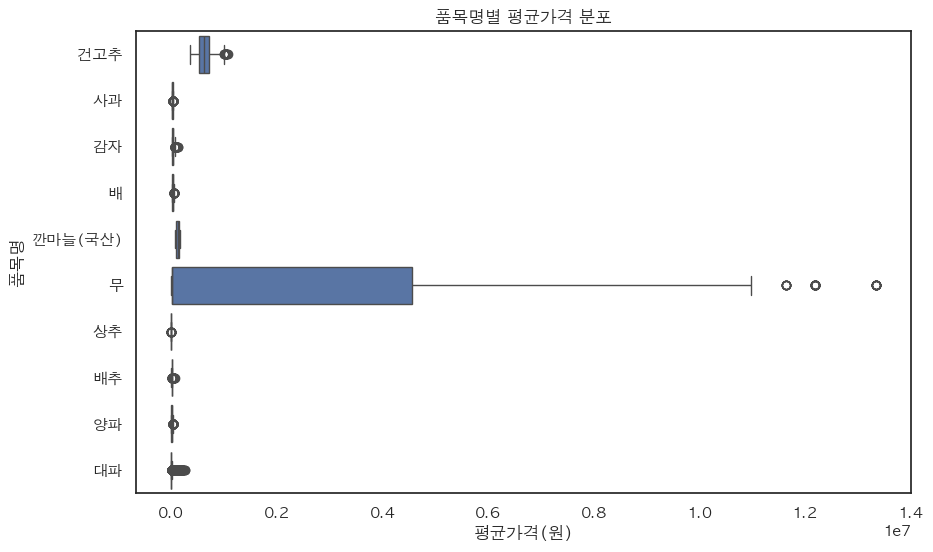

In [70]:
# 품목명별 박스 플롯 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(x='평균가격(원)', y='품목명', data=train_with_target_df)
plt.title('품목명별 평균가격 분포')
plt.show()

- 품종명별 평균가격 분포

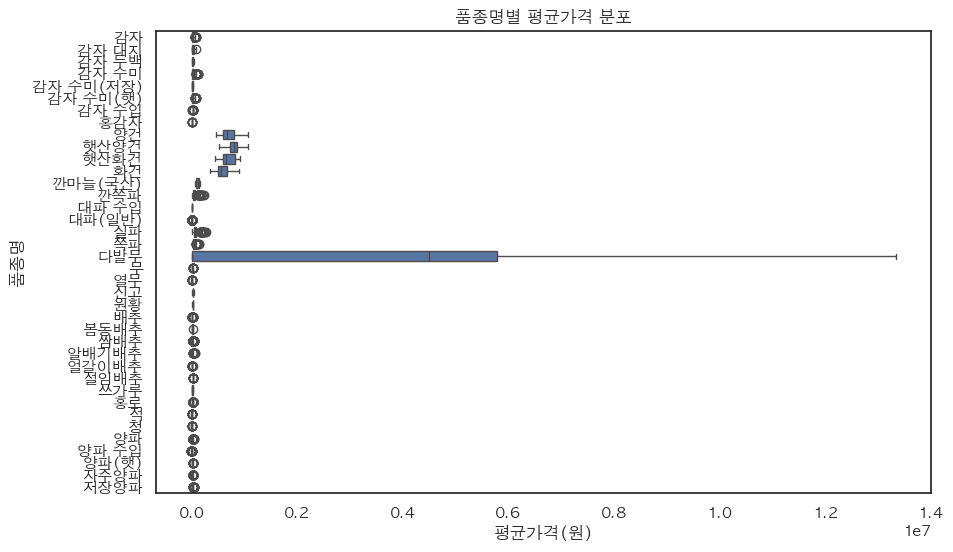

In [71]:
# 품종명별 박스 플롯 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(x='평균가격(원)', y='품종명', data=train_with_target_df.sort_values(['품목명','품종명']))
plt.title('품종명별 평균가격 분포')
plt.show()

- 거래단위별 평균가격 분포

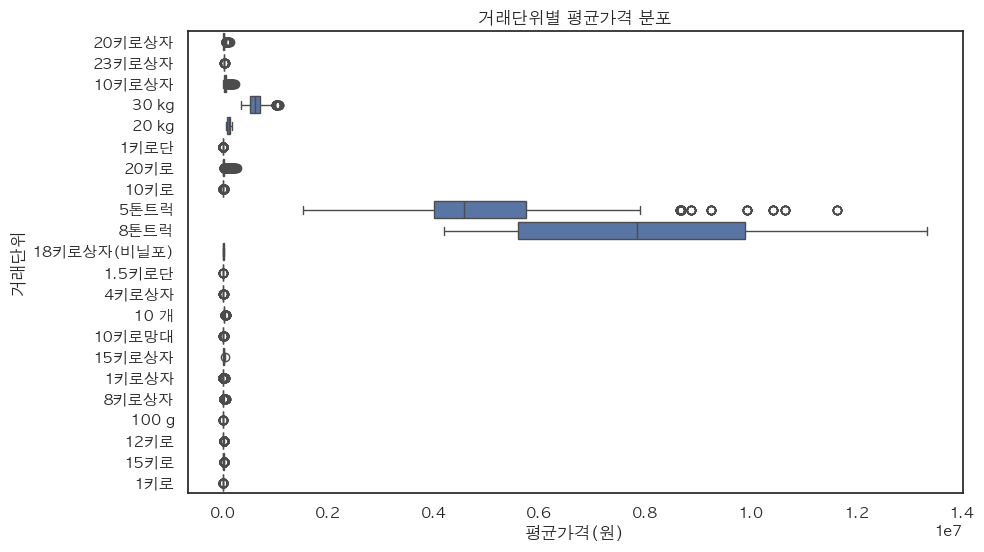

In [72]:
# 거래단위별 박스 플롯 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(x='평균가격(원)', y='거래단위', data=train_with_target_df.sort_values(['품목명','품종명','거래단위']))
plt.title('거래단위별 평균가격 분포')
plt.show()

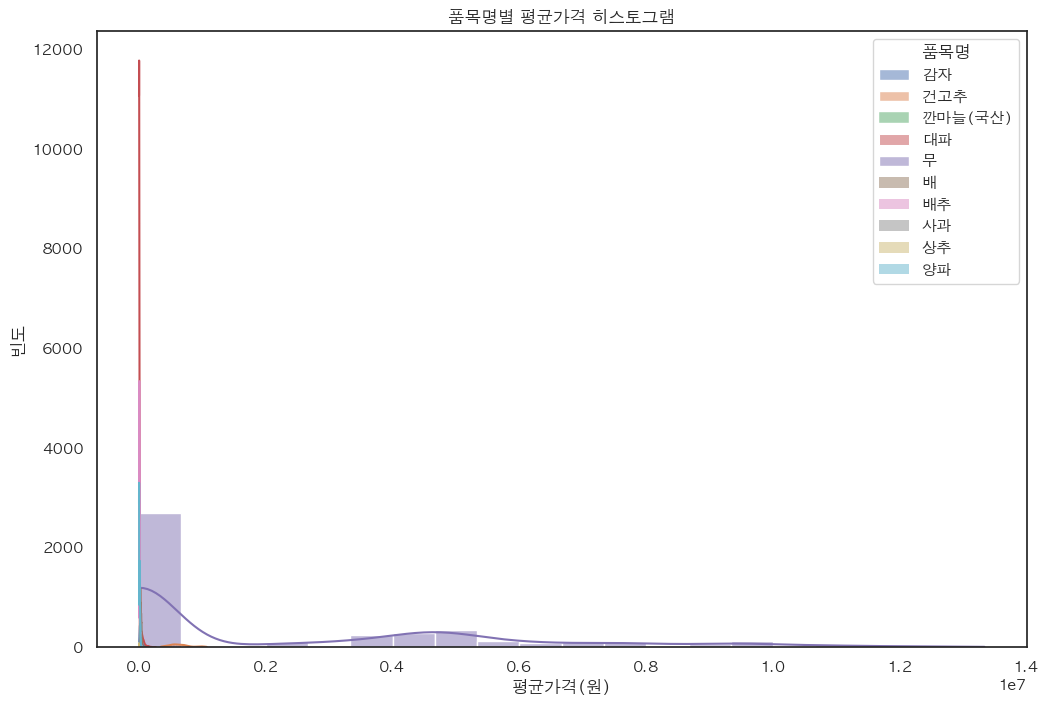

In [73]:
# 품목명별로 평균가격의 히스토그램 그리기
plt.figure(figsize=(12, 8))

for 품목명, group in train_with_target_df.groupby('품목명'):
    sns.histplot(group['평균가격(원)'], kde=True, label=품목명, bins=20)

plt.legend(title='품목명')
plt.title('품목명별 평균가격 히스토그램')
plt.xlabel('평균가격(원)')
plt.ylabel('빈도')
plt.show()

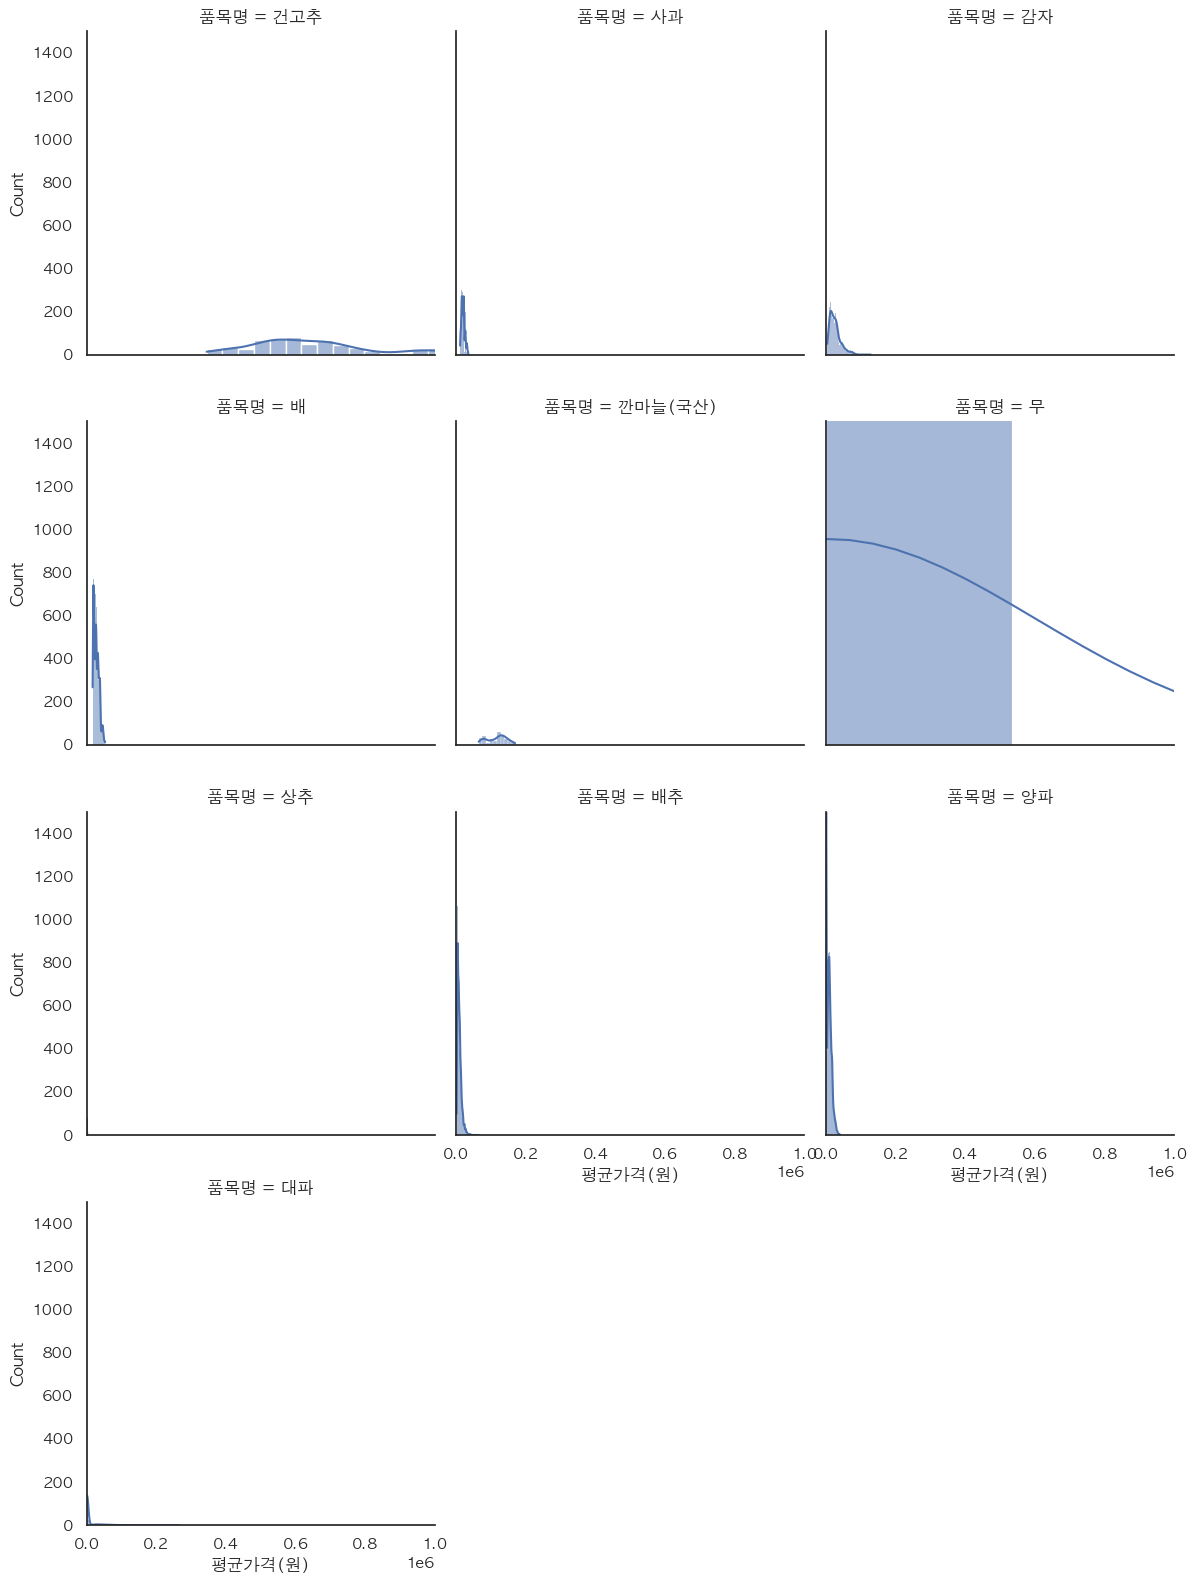

In [74]:
# 품목명별로 개별 히스토그램 그리기
g = sns.FacetGrid(train_with_target_df, col='품목명', col_wrap=3, height=4)
g.map(sns.histplot, '평균가격(원)', kde=True)
g.set(xlim=(0, 1e6), ylim=(0, 1500))
plt.show()

- '건고추' 품목의 평균 거래 가격이 높다.
- '무' 품목 중 '다발무' 품종의 가격이 굉장히 높은 경우가 존재한다.
  - 대량 거래 건일 것 같다.
- 이런 튀는 값들을 처리하기 위해선, 거래 가격이 아니라 단위 가격을 계산해서 사용하는 것이 좋아 보임

---
- 단위가격(=중량별가격) 계산
  - 양을 나타낼 수 있는 공통된 기준별 가격을 계산해야 함.
  - 평균가격 = 거래단위 * 단위가격(=중량별가격)
  - 단위가격을 (1g 당 가격) 으로 설정
  - 거래단위를 g 단위로 변환해야 함
- '거래단위'를 '거래수량'과 '단위기준'으로 분리
  - '단위기준별중량' 을 정의
  - 평균가격 = 거래수량 * 단위기준 * 단위기준별중량 * 중량별가격(=단위가격)

In [75]:
# 거래 단위 분리
set(train_df['거래단위']) # 전체 거래단위

{'1.5키로단',
 '10 개',
 '100 g',
 '1000키로',
 '10키로',
 '10키로망대',
 '10키로묶음',
 '10키로상자',
 '12키로',
 '15키로',
 '15키로상자',
 '18키로상자(비닐포)',
 '1키로',
 '1키로단',
 '1키로상자',
 '20 kg',
 '20키로',
 '20키로상자',
 '23키로상자',
 '30 kg',
 '4키로상자',
 '5000키로',
 '5톤트럭',
 '8키로상자',
 '8톤트럭'}

In [76]:
def split_transaction_unit(data):
    import re
    match = re.match(r"([0-9.,]+)([^\d]*)", data)  # 숫자와 문자를 분리하는 정규 표현식
    if match:
        return (match.group(1), match.group(2).strip())

In [77]:
단위기준 = set()
for data in set(train_df['거래단위']):
    value_unit = split_transaction_unit(data)
    단위기준.add(value_unit[-1])

In [78]:
단위기준

{'g', 'kg', '개', '키로', '키로단', '키로망대', '키로묶음', '키로상자', '키로상자(비닐포)', '톤트럭'}

In [79]:
import re

# 숫자와 문자로 나누기
numbers = []
texts = []

for item in set(train_df['거래단위']):
    match = re.match(r"([0-9.,]+)([^\d]*)", item)  # 숫자와 문자를 분리하는 정규 표현식
    if match:
        numbers.append(match.group(1))  # 숫자 부분
        texts.append(match.group(2).strip())  # 문자 부분

# 결과 출력
print("숫자 부분:", numbers)
print("문자 부분:", texts)

숫자 부분: ['15', '10', '4', '1', '12', '8', '20', '20', '8', '10', '23', '10', '15', '5', '10', '1', '5000', '20', '10', '1000', '18', '1.5', '30', '1', '100']
문자 부분: ['키로상자', '키로', '키로상자', '키로', '키로', '키로상자', 'kg', '키로상자', '톤트럭', '개', '키로상자', '키로상자', '키로', '톤트럭', '키로묶음', '키로단', '키로', '키로', '키로망대', '키로', '키로상자(비닐포)', '키로단', 'kg', '키로상자', 'g']


---
## 3. 관계 분석
### 3-1. 속성 조합간 패턴 분석

- 품종별로 1kg 당 평균가격의 추이를 확인하면 각 품종의 단위 가치를 알 수 있다.
- 추가로 1kg 당 평균가격의 추이를 평균가격을 거래중량으로 나눈 값을 비교해 1kg 당 평균가격이 비어있는 대상들을 계산할 수 있다.

In [80]:
UNIT_TO_GRAM = {
    'g': 1,
    'kg': 1_000,
    '개': {
        '신고': 1_000,
        '원황': 1_000,
        '홍로': 750,
    },
    '키로': 1_000,
    '키로단': 1_000,
    '키로망대': 1_000,
    '키로묶음': 1_000,
    '키로상자': 2_000,
    '키로상자(비닐포)': 1_000,
    '톤트럭': 1_000_000,
}

In [81]:
def parse_to_gram(df):
    import re
    match = re.match(r"([0-9.,]+)([^\d]*)", df['거래단위'])  # 숫자와 문자를 분리하는 정규 표현식
    if match:
        num = float(match.group(1))
        unit = match.group(2).strip()
        if unit == '개':
            if df['품종명'] not in UNIT_TO_GRAM[unit]: return num * 500
            return num * UNIT_TO_GRAM[unit][df['품종명']]
        return num * UNIT_TO_GRAM[unit]

In [82]:
train_with_target_df['g당평균가격'] = train_with_target_df['평균가격(원)'] / train_with_target_df.apply(parse_to_gram, axis=1)
# train_with_target_df['g당평균가격'] = train_with_target_df['평균가격(원)'] / train_with_target_df[['품종명', '거래단위']].apply(parse_to_gram)
train_with_target_df['kg당평균가격'] = train_with_target_df['g당평균가격'] * 1000

/var/folders/nv/zc1cdl3n45x76yn0d3xn4rwc0000gn/T/ipykernel_75227/358739229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_with_target_df['g당평균가격'] = train_with_target_df['평균가격(원)'] / train_with_target_df.apply(parse_to_gram, axis=1)
/var/folders/nv/zc1cdl3n45x76yn0d3xn4rwc0000gn/T/ipykernel_75227/358739229.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_with_target_df['kg당평균가격'] = train_with_target_df['g당평균가격'] * 1000


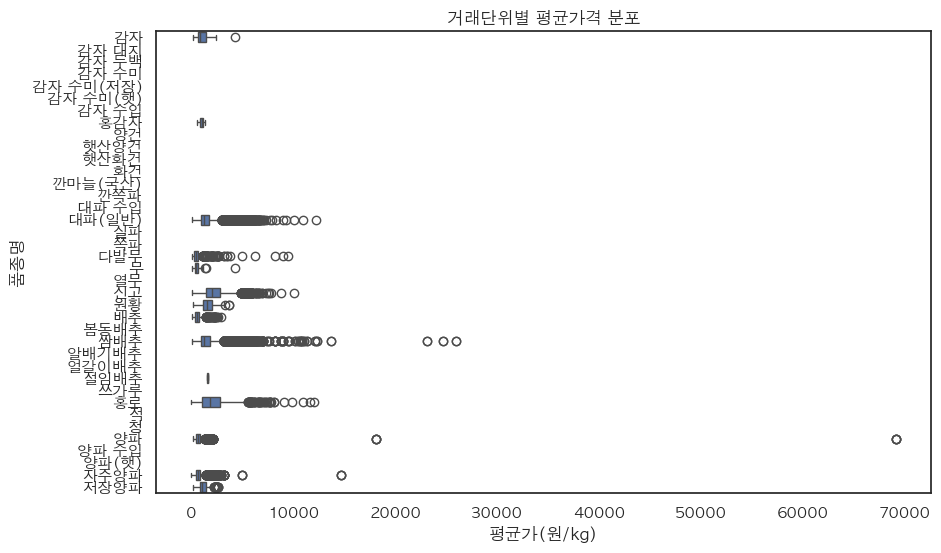

In [83]:
# 거래단위별 박스 플롯 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(x='평균가(원/kg)', y='품종명', data=train_with_target_df.sort_values(['품목명','품종명','거래단위']))
plt.title('거래단위별 평균가격 분포')
plt.show()

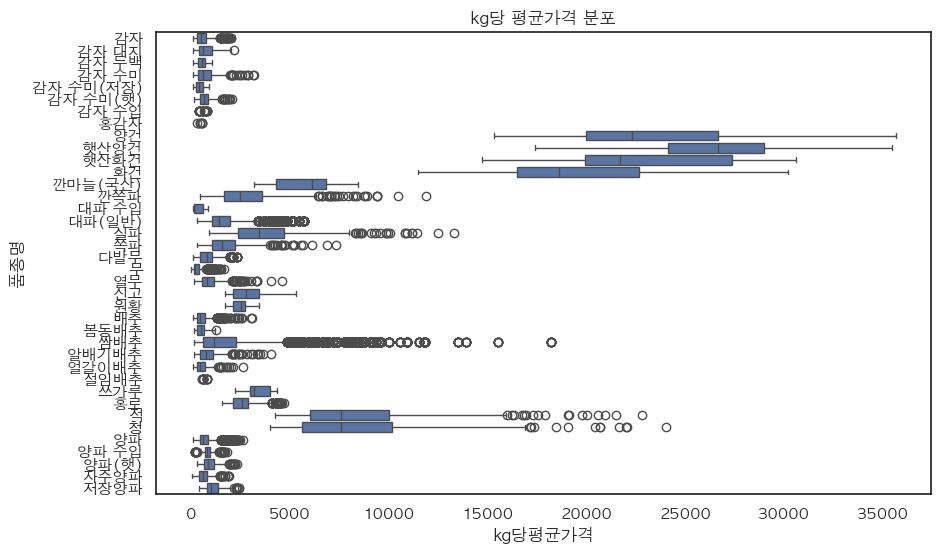

In [84]:
# 품종별 g당가격 박스 플롯 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(x='kg당평균가격', y='품종명', data=train_with_target_df.sort_values(['품목명','품종명','거래단위']))
plt.title('kg당 평균가격 분포')
plt.show()

- 양건, 햇산양건, 햇산화건, 화건, 적, 청, 깐마늘(국산) 품종들이 단위가 크게 튐
- 해당 품종들의 거래단위에 특이한 점이 있는지 확인

In [85]:
train_with_target_df.loc[train_with_target_df['품종명'].isin(['양건', '햇산양건', '햇산화건', '화건', '적', '청', '깐마늘(국산)']), :].groupby(['품목명', '품종명'])['거래단위'].agg(set)

품목명      품종명    
건고추      양건         {30 kg}
         햇산양건       {30 kg}
         햇산화건       {30 kg}
         화건         {30 kg}
깐마늘(국산)  깐마늘(국산)    {20 kg}
상추       적          {100 g}
         청          {100 g}
Name: 거래단위, dtype: object

- 거래단위는 일반적인 중량 단위로, 특이점은 없어보임. 단순히 해당 품목들의 거래가치가 높은 걸로 보임

In [86]:
train_with_target_df['kg당가격편차'] = train_with_target_df['kg당평균가격'] - train_with_target_df['평균가(원/kg)']

/var/folders/nv/zc1cdl3n45x76yn0d3xn4rwc0000gn/T/ipykernel_75227/1367045342.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_with_target_df['kg당가격편차'] = train_with_target_df['kg당평균가격'] - train_with_target_df['평균가(원/kg)']


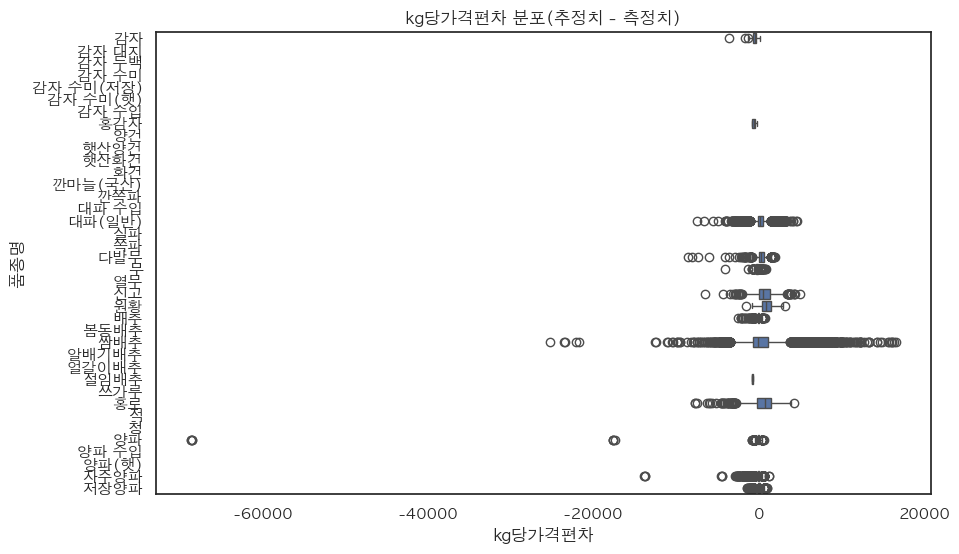

In [87]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='kg당가격편차', y='품종명', data=train_with_target_df.sort_values(['품목명','품종명','거래단위']))
plt.title('kg당가격편차 분포(추정치 - 측정치)')
plt.show()

In [88]:
train_with_target_df[['kg당가격편차', 'kg당평균가격', '평균가(원/kg)']].describe()

,kg당가격편차,kg당평균가격,평균가(원/kg)
count,50620.000000,63848.000000,50620.000000
mean,304.145895,1871.970304,1426.684789
std,1421.239242,2533.643968,1249.417604
min,-68612.414815,41.605556,0.000000
25%,-216.945880,645.133333,700.000000
50%,75.291347,1160.777778,1134.498250
75%,704.593996,2329.500000,1818.025980
max,16605.407115,35669.166667,69200.000000


In [89]:
train_with_target_df.groupby(['품목명', '품종명'])['kg당가격편차'].describe().sort_values(by='mean', ascending=False)

count        mean          std           min         25%  \
품목명     품종명                                                                     
배       원황           861.0  935.935952   743.720888  -1526.766667  405.279186   
        신고          8845.0  682.564422   957.749167  -6526.685185   34.359477   
사과      홍로          3995.0  608.985411  1272.113212  -7712.000000 -231.112375   
배추      쌈배추        13169.0  370.419655  2078.008598 -25251.243056 -705.626432   
무       다발무         2378.0  309.668787   569.625434  -8600.000000   31.595105   
대파      대파(일반)      8308.0  216.525620   659.175936  -7519.888889 -100.768625   
양파      저장양파        1381.0   15.305096   313.683673  -1414.650317 -126.268429   
        자주양파        7051.0  -62.632084   416.385312 -13845.222222 -133.462129   
배추      배추           841.0  -79.442533   306.645288  -2455.706548 -146.619453   
양파      양파          2718.0 -172.311249  2718.204875 -68612.414815 -148.538255   
무       무            669.0 -185.194789   269.110253  -4124.207088 -293.570194   
감자      감자           374.0 -521.307152   338.014927  -3594.202778 -723.304806   
        홍감자           24.0 -605.595017   192.385345   -869.028287 -782.712500   
배추      절임배추           6.0 -744.038375    37.391407   -770.843750 -769.483507   
감자      감자 대지          0.0         NaN          NaN           NaN         NaN   
        감자 두백          0.0         NaN          NaN           NaN         NaN   
        감자 수미          0.0         NaN          NaN           NaN         NaN   
        감자 수미(저장)      0.0         NaN          NaN           NaN         NaN   
        감자 수미(햇)       0.0         NaN          NaN           NaN         NaN   
        감자 수입          0.0         NaN          NaN           NaN         NaN   
건고추     양건             0.0         NaN          NaN           NaN         NaN   
        햇산양건           0.0         NaN          NaN           NaN         NaN   
        햇산화건           0.0         NaN          NaN           NaN         NaN   
        화건             0.0         NaN          NaN           NaN         NaN   
깐마늘(국산) 깐마늘(국산)        0.0         NaN          NaN           NaN         NaN   
대파      깐쪽파            0.0         NaN          NaN           NaN         NaN   
        대파 수입          0.0         NaN          NaN           NaN         NaN   
        실파             0.0         NaN          NaN           NaN         NaN   
        쪽파             0.0         NaN          NaN           NaN         NaN   
무       열무             0.0         NaN          NaN           NaN         NaN   
배추      봄동배추           0.0         NaN          NaN           NaN         NaN   
        알배기배추          0.0         NaN          NaN           NaN         NaN   
        얼갈이배추          0.0         NaN          NaN           NaN         NaN   
사과      쓰가루            0.0         NaN          NaN           NaN         NaN   
상추      적              0.0         NaN          NaN           NaN         NaN   
        청              0.0         NaN          NaN           NaN         NaN   
양파      양파 수입          0.0         NaN          NaN           NaN         NaN   
        양파(햇)          0.0         NaN          NaN           NaN         NaN   

                          50%          75%           max  
품목명     품종명                                               
배       원황         877.108067  1443.168856   3192.066667  
        신고         572.079943  1408.135772   4970.700000  
사과      홍로         743.566667  1468.800000   4250.433333  
배추      쌈배추       -117.389019  1109.405109  16605.407115  
무       다발무        319.054944   600.906418   2020.554245  
대파      대파(일반)     114.134436   534.212101   4575.888889  
양파      저장양파        -3.122325   181.763149    954.981481  
        자주양파       -13.745882    87.657461   1190.000000  
배추      배추         -36.051990    59.643754    766.658816  
양파      양파         -37.708823    71.882869    634.809026  
무       무         -185.107335  -107.125600    818.753086  
감자      감자   

- 직접 계산한 값과 meta 데이터의 편차를 살펴봤을때, **[신고, 원황, 쌈배추, 홍로]** 품종이 편차가 큰 것을 확인할 수 있음.
- 추정치가 더 큰 상황이므로, 해당 품종들의 무게 측정이 실제보다 가볍게 처리한 것으로 보임
- 해당 품종들의 거래단위를 확인하고, 중량 계산시 단위를 수정해야 함

In [90]:
train_with_target_df.loc[train_with_target_df['품종명'].isin(['신고', '원황','쌈배추', '홍로']), ['품종명', '거래단위']].groupby('품종명')['거래단위'].agg(set)

품종명
신고             {10 개}
쌈배추    {8키로상자, 1키로상자}
원황             {10 개}
홍로             {10 개}
Name: 거래단위, dtype: object

- 해당 품종들의 거래단위를 확인해보니, **'개', '상자'** 단위로 파는 것들에 오차가 생겼음을 알 수 있음
- 신고, 원황, 홍로 품종들의 평균 크기를 조사해서 해당 크기로 처리하도록 수정
  - 신고배는 7.5kg 에 10개입으로 판매되는 것으로 보임: 평균 750g [참고](https://emart.ssg.com/item/itemView.ssg?itemId=1000560718484&siteNo=6001&salestrNo=6005&tlidSrchWd=%EC%8B%A0%EA%B3%A0%EB%B0%B0&srchPgNo=1&advertBidId=9999999998)
  - 원황배는 5kg, 7,5kg 단위로 판매되는 것으로 보아, 중간값인 625g 정도로 처리하면 될 듯
  - 홍로는 300 ~ 350g 정도라고 한다.
- 상자는 값을 크게 조정

- 평균가를 사용할 것이기 때문에, .0으로 결측치인 값들을 채워줘야 한다.
- 위에서 추정한 kg당 가격편차를 사용하도록 한다.

In [91]:
idx = (train_with_target_df['평균가(원/kg)'] == .0)
train_with_target_df.loc[idx, '평균가(원/kg)'] = train_with_target_df.loc[idx, 'kg당평균가격']

In [92]:
train_with_target_df.describe()

,평년 평균가격(원),평균가격(원),시장코드,품목코드,품종코드,총반입량(kg),총거래금액(원),평균가(원/kg),중간가(원/kg),최저가(원/kg),최고가(원/kg),경매 건수,전순 평균가격(원) PreVious SOON,전달 평균가격(원) PreVious MMonth,전년 평균가격(원) PreVious YeaR,평년 평균가격(원) Common Year SOON,연도,평균가(원/kg)_mean,g당평균가격,kg당평균가격,kg당가격편차
count,6.384800e+04,6.384800e+04,5.062000e+04,50620.000000,50620.000000,5.062000e+04,5.062000e+04,50620.000000,5.062000e+04,50620.000000,5.062000e+04,50620.000000,50620.000000,50620.000000,5.062000e+04,5.062000e+04,50620.000000,50620.000000,63848.000000,63848.000000,50620.000000
mean,4.648825e+04,1.794157e+05,1.282653e+09,972.057171,97211.045358,1.073826e+05,1.595473e+08,1426.820064,1.477064e+03,814.846787,4.109086e+03,75.069597,1314.553770,1287.420265,6.403426e+03,1.493220e+04,2019.482438,1431.776822,1.871970,1871.970304,304.145895
std,3.591459e+05,1.032151e+06,2.039246e+09,245.612749,24559.832995,6.541497e+05,1.303625e+09,1249.357016,6.715903e+03,1056.858182,5.677481e+04,375.141832,1576.667198,3752.427388,9.687622e+04,1.519959e+05,1.095883,664.524208,2.533644,2533.643968,1421.239242
min,0.000000e+00,1.341250e+02,1.000000e+05,501.000000,50100.000000,0.000000e+00,0.000000e+00,17.763158,0.000000e+00,0.000000,0.000000e+00,1.000000,-252.525253,-252.525253,-2.525253e+02,0.000000e+00,2018.000000,330.497590,0.041606,41.605556,-68612.414815
25%,0.000000e+00,3.468571e+03,2.500010e+05,602.000000,60201.000000,9.540000e+02,1.039930e+06,700.000000,7.075000e+02,277.541667,1.000000e+03,5.000000,566.559710,467.672414,4.594317e+02,0.000000e+00,2019.000000,907.328886,0.645133,645.133333,-216.945880
50%,0.000000e+00,9.998333e+03,3.503010e+05,1001.000000,100108.000000,6.825000e+03,7.291900e+06,1134.554236,1.150000e+03,571.259305,1.845329e+03,18.000000,1050.983408,980.306024,1.075450e+03,0.000000e+00,2019.000000,1408.588925,1.160778,1160.777778,75.291347
75%,1.427433e+04,2.110200e+04,3.048206e+09,1201.000000,120106.000000,3.540000e+04,4.283400e+07,1818.426422,1.831722e+03,1066.666667,3.377288e+03,52.000000,1745.515740,1687.601320,1.999633e+03,5.514723e+03,2020.000000,1868.553016,2.329500,2329.500000,704.593996
max,5.213802e+06,1.335000e+07,6.738200e+09,1202.000000,120201.000000,2.962043e+07,7.496361e+10,69200.000000,1.050700e+06,69200.000000,4.216786e+06,18795.000000,222934.397622,748144.028290,3.494734e+06,3.699690e+06,2021.000000,3496.526883,35.669167,35669.166667,16605.407115


---
### 3-2. 시각화 및 속성간 관계 분석

#### 품종별 가치 변화
- 평균가를 채웠으니 거래되는 각 품종들의 가치가 시간에 따라 어떻게 변화하는지 확인할 수 있음

In [93]:
train_with_target_df.columns

Index(['시점', '품목명', '품종명', '거래단위', '등급', '평년 평균가격(원)', '평균가격(원)', '시장코드',
       '시장명', '품목코드', '품종코드', '총반입량(kg)', '총거래금액(원)', '평균가(원/kg)', '중간가(원/kg)',
       '최저가(원/kg)', '최고가(원/kg)', '경매 건수', '전순 평균가격(원) PreVious SOON',
       '전달 평균가격(원) PreVious MMonth', '전년 평균가격(원) PreVious YeaR',
       '평년 평균가격(원) Common Year SOON', '연도', '시장구분', '평균가(원/kg)_mean', 'g당평균가격',
       'kg당평균가격', 'kg당가격편차'],
      dtype='object')

In [103]:
train_with_target_df.groupby('품목명')['시점'].agg(list)

품목명
감자         [201801상순, 201801중순, 201801하순, 201802상순, 20180...
건고추        [201801상순, 201801중순, 201801하순, 201802상순, 20180...
깐마늘(국산)    [201801상순, 201801중순, 201801하순, 201802상순, 20180...
대파         [201801상순, 201801상순, 201801상순, 201801상순, 20180...
무          [201801상순, 201801중순, 201801하순, 201802상순, 20180...
배          [201801상순, 201801상순, 201801상순, 201801상순, 20180...
배추         [201801상순, 201801중순, 201801하순, 201802상순, 20180...
사과         [201801상순, 201801중순, 201801하순, 201802상순, 20180...
상추         [201801상순, 201801중순, 201801하순, 201802상순, 20180...
양파         [201801상순, 201801중순, 201801하순, 201802상순, 20180...
Name: 시점, dtype: object

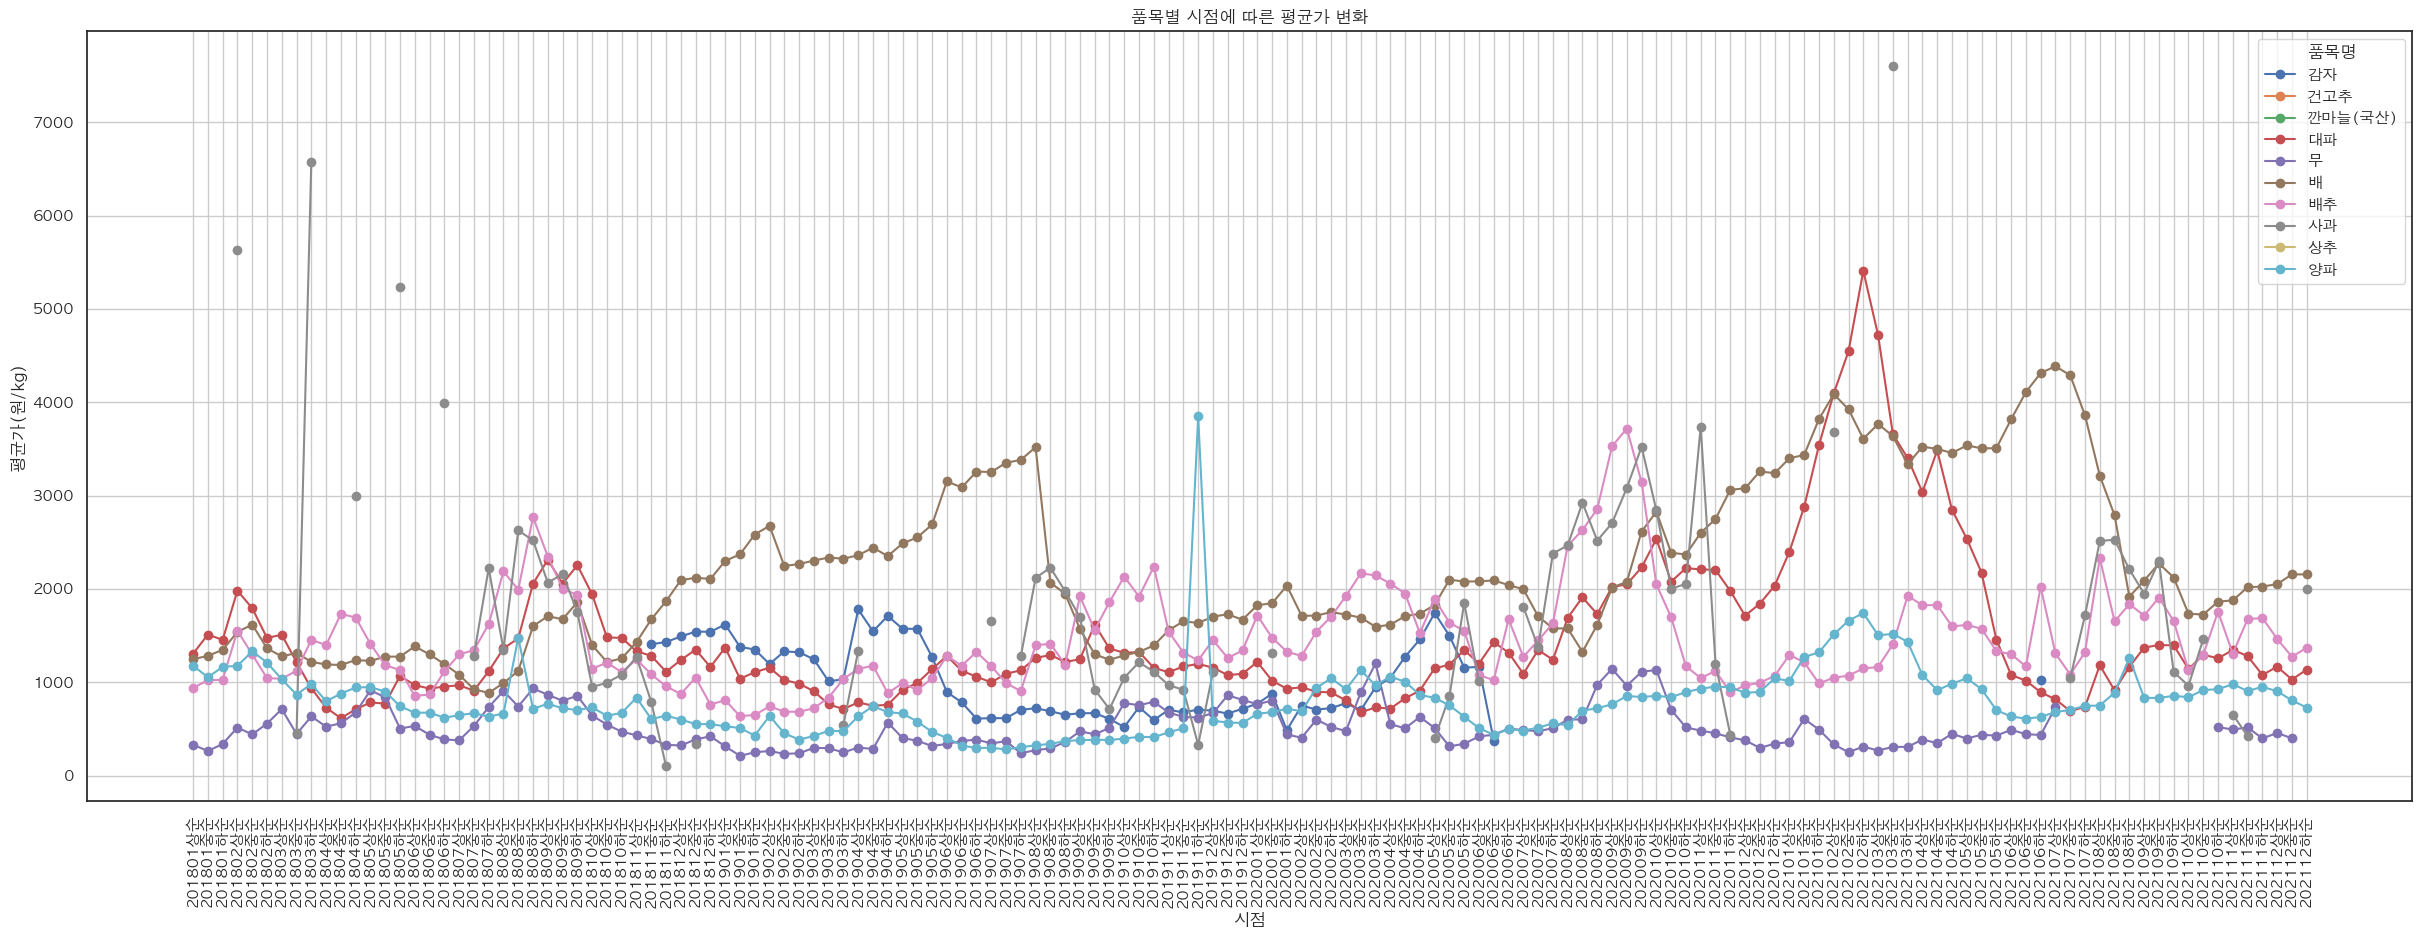

In [111]:
# 품목별로 시점에 따른 평균가(원/kg)의 변화를 계산
grouped = train_with_target_df.groupby(['품목명', '시점'])['평균가(원/kg)'].mean().unstack()

# 그래프 크기 설정
plt.figure(figsize=(30, 10))

# 각 품목별로 꺾은선 그래프 그리기
for 품목명 in grouped.index:
    plt.plot(grouped.columns, grouped.loc[품목명], marker='o', label=품목명)

# 그래프 레이블 및 제목
plt.xlabel('시점')
plt.xticks(rotation=90)
plt.ylabel('평균가(원/kg)')
plt.title('품목별 시점에 따른 평균가 변화')
plt.legend(title='품목명')
plt.grid(True)

# 그래프 출력
plt.show()

/var/folders/nv/zc1cdl3n45x76yn0d3xn4rwc0000gn/T/ipykernel_75227/3835926812.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(grouped.columns, rotation=90)
/var/folders/nv/zc1cdl3n45x76yn0d3xn4rwc0000gn/T/ipykernel_75227/3835926812.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(grouped.columns, rotation=90)
/var/folders/nv/zc1cdl3n45x76yn0d3xn4rwc0000gn/T/ipykernel_75227/3835926812.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(grouped.columns, rotation=90)
/var/folders/nv/zc1cdl3n45x76yn0d3xn4rwc0000gn/T/ipykernel_75227/3835926812.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

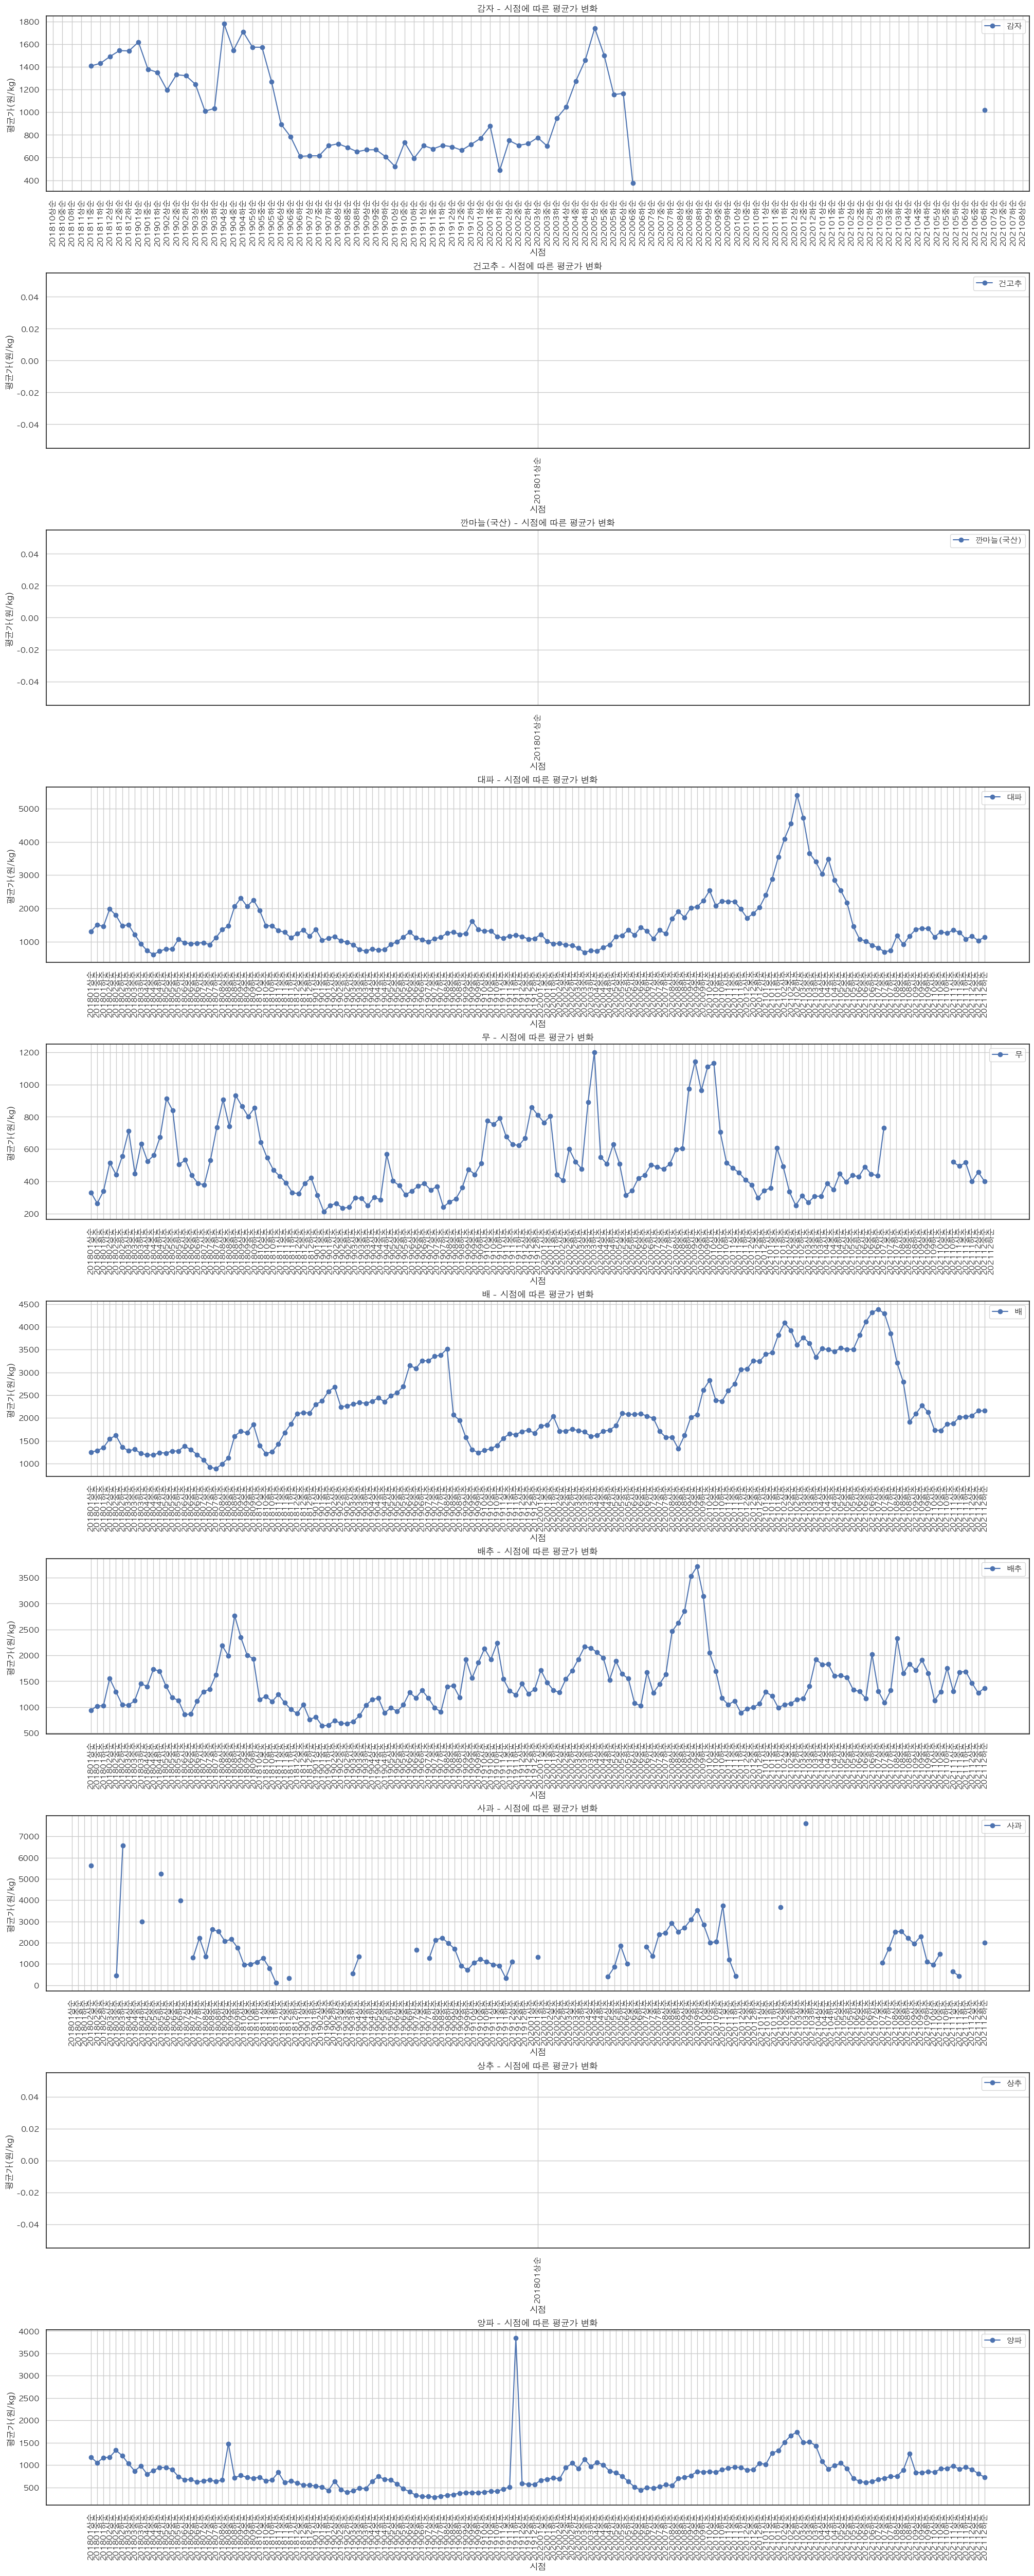

In [113]:
# 품목별로 시점에 따른 평균가(원/kg)의 변화를 계산
grouped = train_with_target_df.groupby(['품목명', '시점'])['평균가(원/kg)'].mean().unstack()

# 그래프 크기 설정 (서브플롯을 여러개로 만들기)
n_items = len(grouped.index)
fig, axes = plt.subplots(n_items, 1, figsize=(20, 5 * n_items), constrained_layout=True)

# 각 품목별로 개별 꺾은선 그래프 그리기
for i, 품목명 in enumerate(grouped.index):
    ax = axes[i] if n_items > 1 else axes  # 만약 품목이 하나만 있으면 인덱싱이 필요 없음
    ax.plot(grouped.columns, grouped.loc[품목명], marker='o', label=품목명)
    
    ax.set_xlabel('시점')
    ax.set_xticklabels(grouped.columns, rotation=90)
    ax.set_ylabel('평균가(원/kg)')
    ax.set_title(f'{품목명} - 시점에 따른 평균가 변화')
    ax.legend()
    ax.grid(True)

# 그래프 출력
plt.show()

- 품목별로 계절성/주기성을 확인할 수 있음
  - 수확철 등인 경우 가격에 변동이 생길 수 있을 것
- 하지만 테스트 데이터는 시점정보를 활용할 수 없음
- 따라서 특정 시점을 통해 얻을 수 있는 정보는 사용할 수 없다

---
### 3-3. 상관계수 확인

---